In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler

import causalpy as cp
from causalpy.pymc_experiments import InstrumentalVariable
from causalpy.pymc_models import InstrumentalVariableRegression

In [2]:
%config InlineBackend.figure_format = 'retina'
seed = 42
np.random.seed(seed)

## Instrumental Regression and Multiple Instruments

In this demonstration we will look into the infamous econometric question of returns to schooling. Importantly we'll see that the factors which determine success in schooling and subsequent employment are diverse and determined by social demographics and ability. Consequently there are legitimate concerns about how the effects schooling cannot be cleanly assessed without trying to account for the confounding relationships between ability and schooling. The suggestion from the econometric literature is to leverage instrumental variable regression to decompose the effect of schooling and future wage acquisition. 

In particular the suggestion is that we can use an individual's (assumed as-if random) proximity to a 4-year college as an instrument. Recall that this instrument `nearcollege` has to be: (i) __relevent__ that it effects the causal path of interest interest i.e. nearness to a college is assumed to have a causal impact on an individual's `education`, (ii) __independent__ assignment to instrument be as good as randomly assigned to mitigate the original selection effect bias and (iii) meets the __exclusion restriction__ the instrument should influence the outcome `wage` only through the treatment of interest `education`. If these conditions are met then, we can argue that the instrumental variable regression techniques can distil the causal impact of our treatment. 

In many ways instrumental variable regression is a paradigmatic method of the credibility revolution in econometrics and the social sciences. As such we will elaborate how to explore the assumptions of the design and highlight the conditions under which it can be sensibly applied. 

### Regression Mechanics and (L)ocal(A)verage(T)reatment(E)ffect

The structure of an instrumental variable problem helps us get at the question of causal impact, but it does not target the typical ATE causal estimand. Instead we must be happy with estimate the LATE quantity. This makes sense because implicitly evaluating the effect of a treatment in a population where there is no guarantee of compliance. So we can't make the more general claim to have assessed change on average. It is rather an evaluation of change in the sub-population that have been induced to comply with our design

The theory of the LATE estimator is rich. There are multiple ways of isolating the LATE estimate. 

$$\tau = LATE= \frac{E[Y | Z = 1] - E[Y | Z = 0]}{E[T | Z = 1] - E[T | Z = 0]} = \frac{\phi}{\psi} = \frac{\text{reduced form}}{\text{first stage}} $$

The last phrasing there is highlights the fact that we're interested in two components of variation due to our instrument $Z$. This is one way of seeing that we're trying to estimate a __joint distribution__ of two random variables in a structural equation model. But more importantly we're assuming via __relevance__ that there is some non-trivial correlation between the realisations of the instrument $Z$, the treatment $T$ and the outcome $Y$. 

### Digression: Sampling Multivariate Normals

In the `CausalPy` implementation of instrumental variable regression we model this correlation explicity using an LKJ Cholesky prior on a Multivariate Normal distribution. It's worth a small digression here to show how sampling from this distribution under different priors can shape the correlations of the joint-distribution. We'll show below how this offers us a mechanism to impose constraints on our beliefs about the relationships between our instruments. 

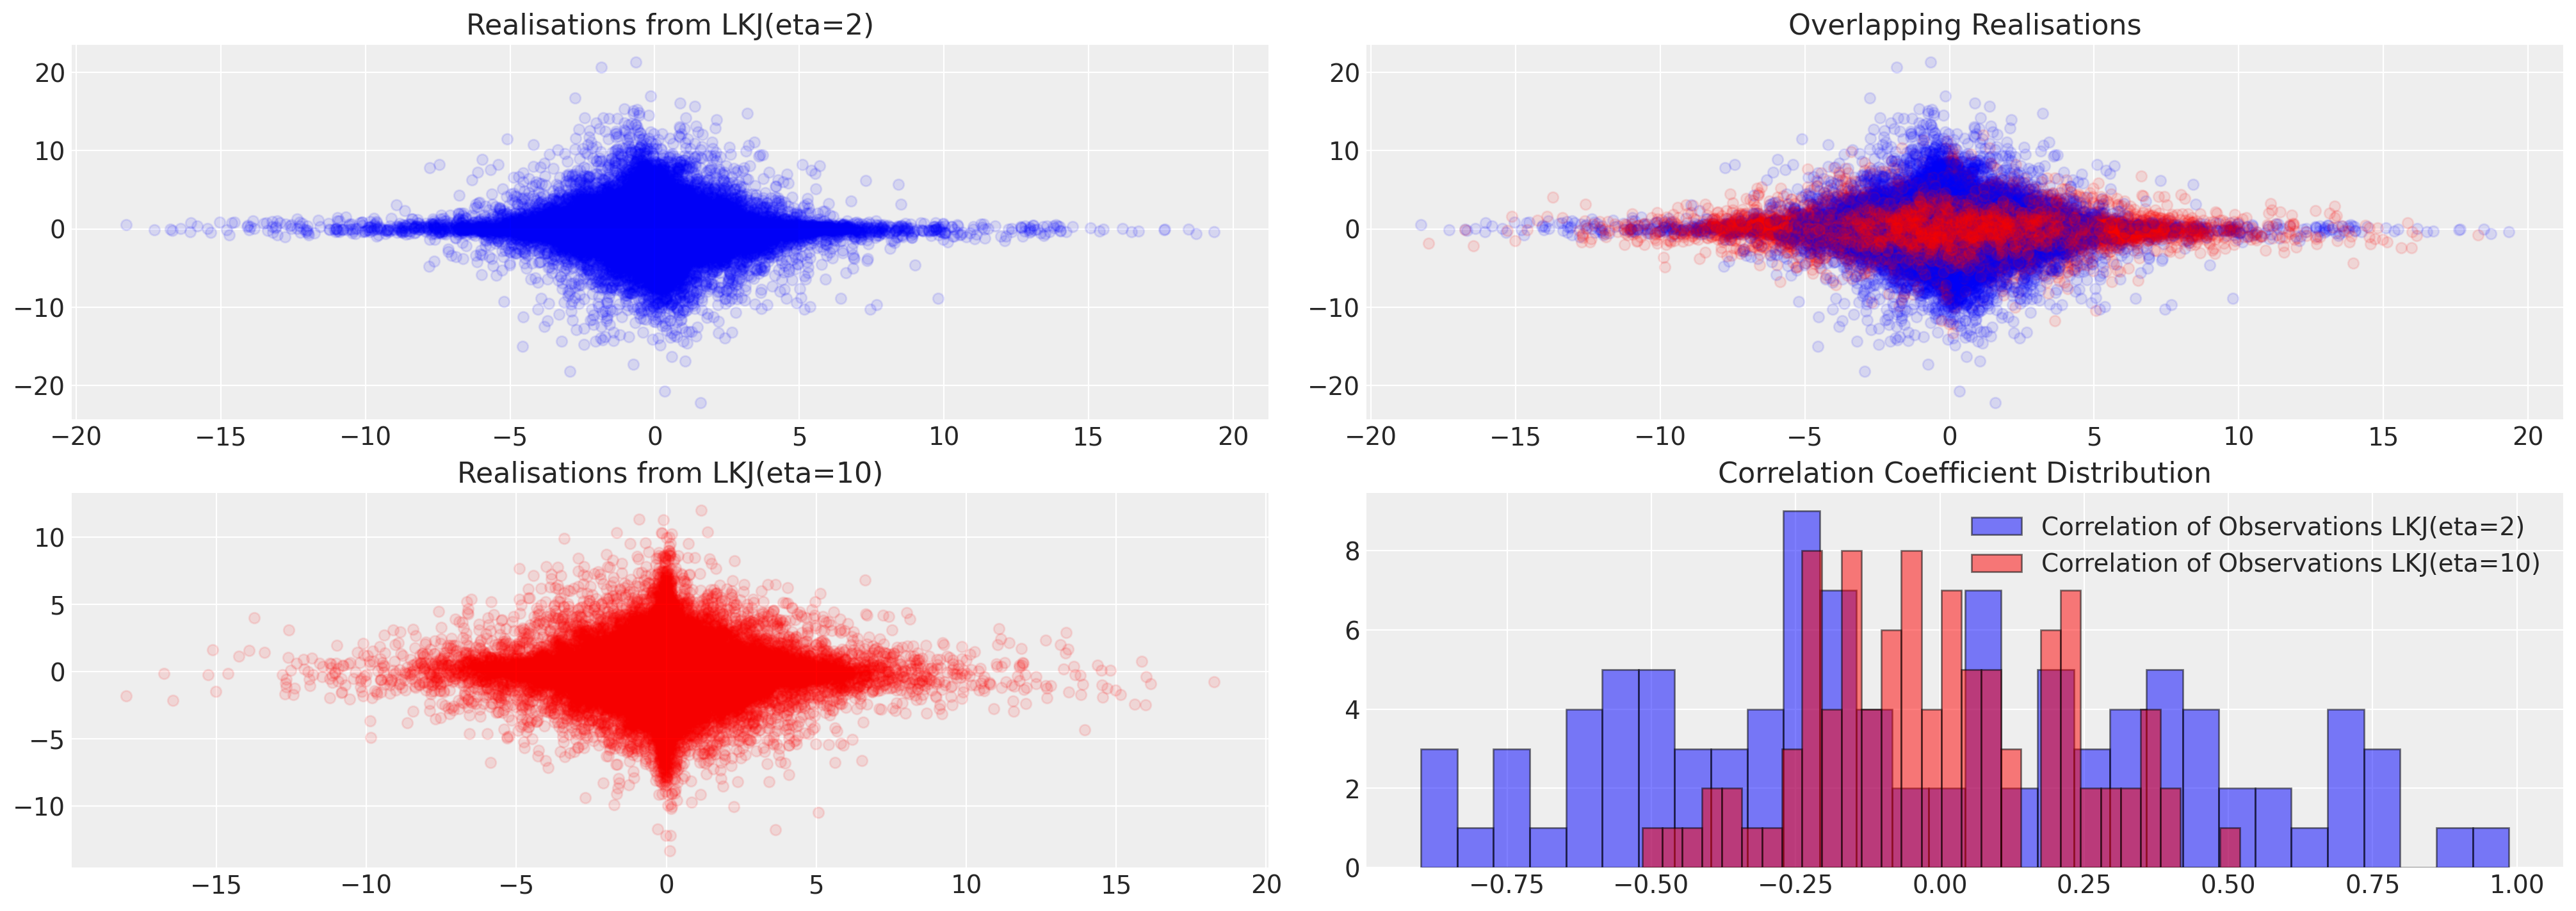

In [3]:
#sd_dist = pm.HalfCauchy.dist(beta=5, shape=2)
sd_dist = pm.Exponential.dist(1.0, shape=2)
lkj = pm.LKJCholeskyCov.dist(
                    eta=2,
                    n=2,
                    sd_dist=sd_dist,
        )
lkj1 = pm.LKJCholeskyCov.dist(
                    eta=10,
                    n=2,
                    sd_dist=sd_dist,
        )
chol, corr, sigmas = pm.draw(lkj, draws=100)
chol1, corr1, sigmas = pm.draw(lkj1, draws=100)

fig, axs = plt.subplots(2, 2, figsize=(20, 7))
axs = axs.flatten()
corrs = []
corrs1 = []
for i in range(100):
        xy = pm.draw(pm.MvNormal.dist(0, chol=chol[i]), 1000)
        xy1 = pm.draw(pm.MvNormal.dist(0, chol=chol1[i]), 1000)
        corrs.append(np.corrcoef(xy[:, 0], xy[:, 1])[0][1])
        corrs1.append(np.corrcoef(xy1[:, 0], xy1[:, 1])[0][1])

        axs[0].scatter(xy[:, 0], xy[:, 1], alpha=0.1, color='blue')
        axs[2].scatter(xy1[:, 0], xy1[:, 1], alpha=0.1, color='red')
        axs[1].scatter(xy[:, 0], xy[:, 1], alpha=0.1, color='blue')
        axs[1].scatter(xy1[:, 0], xy1[:, 1], alpha=0.1, color='red')
axs[3].hist(np.array(corrs), bins=30, 
            ec='black', label='Correlation of Observations LKJ(eta=2)', color='blue', alpha=0.5)
axs[3].hist(np.array(corrs1), bins=30, 
            ec='black', label='Correlation of Observations LKJ(eta=10)', color='red', alpha=0.5)
axs[3].legend()
axs[3].set_title("Correlation Coefficient Distribution")
axs[0].set_title("Realisations from LKJ(eta=2)")
axs[1].set_title("Overlapping Realisations")
axs[2].set_title("Realisations from LKJ(eta=10)");

Here we can see that increasing the `eta` parameter on the LKJ prior shrinks the range of admissable correlations parameters. By default the `CausalPy` implementation sets the `eta=2`. This is worth knowing if your model makes such potential correlations very unlikely. We will show below how you can apply priors to these parameters in the instrumental variable context. 

### The Data: Returns to Schooling

We use a data set from the U.S. National Longitudinal Survey of Young Men (NLSYM) in 1976. This data was sourced from the R `ivreg` package. Originally the data is used to replicate some of the famous work from Card's 1995 paper _Using Geographical Variation in College Proximity to Estimate the Return to Schooling_ in which he aimed to distil the causal impact of education on wages. {cite:t}`card1995returns`

In [4]:
df = cp.load_data("schoolReturns")


def poly(x, p): #replicate R's poly decompostion function
    X = np.transpose(np.vstack([x**k for k in range(p+1)]))
    return np.linalg.qr(X)[0][:,1:]


df['log_wage'] = np.log(df['wage'])
df[['experience_1', 'experience_2']] = pd.DataFrame(poly(df['experience'].values, 2))
df[['age_1', 'age_2']] = poly(df['age'].values, 2)
df['nearcollege_indicator'] = np.where(df['nearcollege'] == 'yes', 1, 0) # 4 year college
df['nearcollege2_indicator'] = np.where(df['nearcollege2'] == 'yes', 1, 0) # 2 year college
df['nearcollege4_indicator'] = np.where(df['nearcollege4'] == 'yes', 1, 0) # 4 year public or private college
df['south_indicator'] = np.where(df['south'] == 'yes', 1, 0) # southern US
df['smsa_indicator'] = np.where(df['smsa'] == 'yes', 1, 0) # standard metropolitan statistical area
df['ethnicity_indicator'] = np.where(df['ethnicity'] == 'afam', 1, 0) # African-American or other
df[['wage', 'education', 'experience','ethnicity', 'nearcollege']]

wage  education  experience ethnicity nearcollege
0      548          7          16      afam          no
1      481         12           9     other          no
2      721         12          16     other          no
3      250         11          10     other         yes
4      729         12          16     other         yes
...    ...        ...         ...       ...         ...
3005   335         12           7     other         yes
3006   481         13          15     other         yes
3007   500         12           6     other         yes
3008   713         12          13     other         yes
3009   525         13           7      afam         yes

[3010 rows x 5 columns]

We can split out the flag features and just look at how the outcome varies conditional on different levels of the population strata. 

In [5]:
(df.assign(age_cut = lambda x: pd.qcut(x['age'], 4)).groupby(['nearcollege', 'smsa', 'ethnicity', 'south', 'age_cut'])[['log_wage']].mean()
 .reset_index().pivot(index=['smsa', 'ethnicity', 'south', 'age_cut'], columns='nearcollege', values='log_wage')
 .reset_index().assign(diff = lambda x: x['no'] - x['yes'])
 .sort_values('diff', ascending=False)
 )

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_33379/2449640862.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df.assign(age_cut = lambda x: pd.qcut(x['age'], 4)).groupby(['nearcollege', 'smsa', 'ethnicity', 'south', 'age_cut'])[['log_wage']].mean()


nearcollege smsa ethnicity south         age_cut        no       yes      diff
10            no     other    no    (28.0, 31.0]  6.359242  6.268868  0.090374
18           yes      afam    no    (28.0, 31.0]  6.384804  6.297580  0.087224
17           yes      afam    no    (25.0, 28.0]  6.304452  6.227144  0.077308
23           yes      afam   yes    (31.0, 34.0]  6.072353  6.008095  0.064259
25           yes     other    no    (25.0, 28.0]  6.380013  6.339782  0.040231
16           yes      afam    no  (23.999, 25.0]  6.121809  6.091255  0.030555
9             no     other    no    (25.0, 28.0]  6.257265  6.229355  0.027911
24           yes     other    no  (23.999, 25.0]  6.269934  6.243692  0.026242
5             no      afam   yes    (25.0, 28.0]  5.823188  5.817938  0.005250
21           yes      afam   yes    (25.0, 28.0]  6.058115  6.055142  0.002974
15            no     other   yes    (31.0, 34.0]  6.286324  6.285786  0.000538
6             no      afam   yes    (28.0, 31.0]  5.760195  5.762354 -0.002160
12            no     other   yes  (23.999, 25.0]  5.949446  5.967792 -0.018346
8             no     other    no  (23.999, 25.0]  6.061968  6.080621 -0.018653
30           yes     other   yes    (28.0, 31.0]  6.406349  6.426017 -0.019667
13            no     other   yes    (25.0, 28.0]  6.078881  6.105373 -0.026492
28           yes     other   yes  (23.999, 25.0]  6.087393  6.147604 -0.060211
29           yes     other   yes    (25.0, 28.0]  6.212912  6.276813 -0.063901
26           yes     other    no    (28.0, 31.0]  6.467614  6.537773 -0.070159
22           yes      afam   yes    (28.0, 31.0]  6.018811  6.089009 -0.070198
1             no      afam    no    (25.0, 28.0]  6.476972  6.551080 -0.074108
27           yes     other    no    (31.0, 34.0]  6.582610  6.667456 -0.084846
4             no      afam   yes  (23.999, 25.0]  5.743832  5.868869 -0.125038
11            no     other    no    (31.0, 34.0]  6.341486  6.477895 -0.136409
14            no     other   yes    (28.0, 31.0]  6.145305  6.287238 -0.141932
7             no      afam   yes    (31.0, 34.0]  5.816205  5.965031 -0.148826
20           yes      afam   yes  (23.999, 25.0]  5.811460  5.970177 -0.158717
19           yes      afam    no    (31.0, 34.0]  6.248533  6.454210 -0.205677
31           yes     other   yes    (31.0, 34.0]  6.292745  6.570037 -0.277292
0             no      afam    no  (23.999, 25.0]       NaN       NaN       NaN
2             no      afam    no    (28.0, 31.0]  5.783825       NaN       NaN
3             no      afam    no    (31.0, 34.0]       NaN  6.341152       NaN

This should just highlight the magnitude of change we might expect in the outcome variable holding all else equal for varying the group membership. 

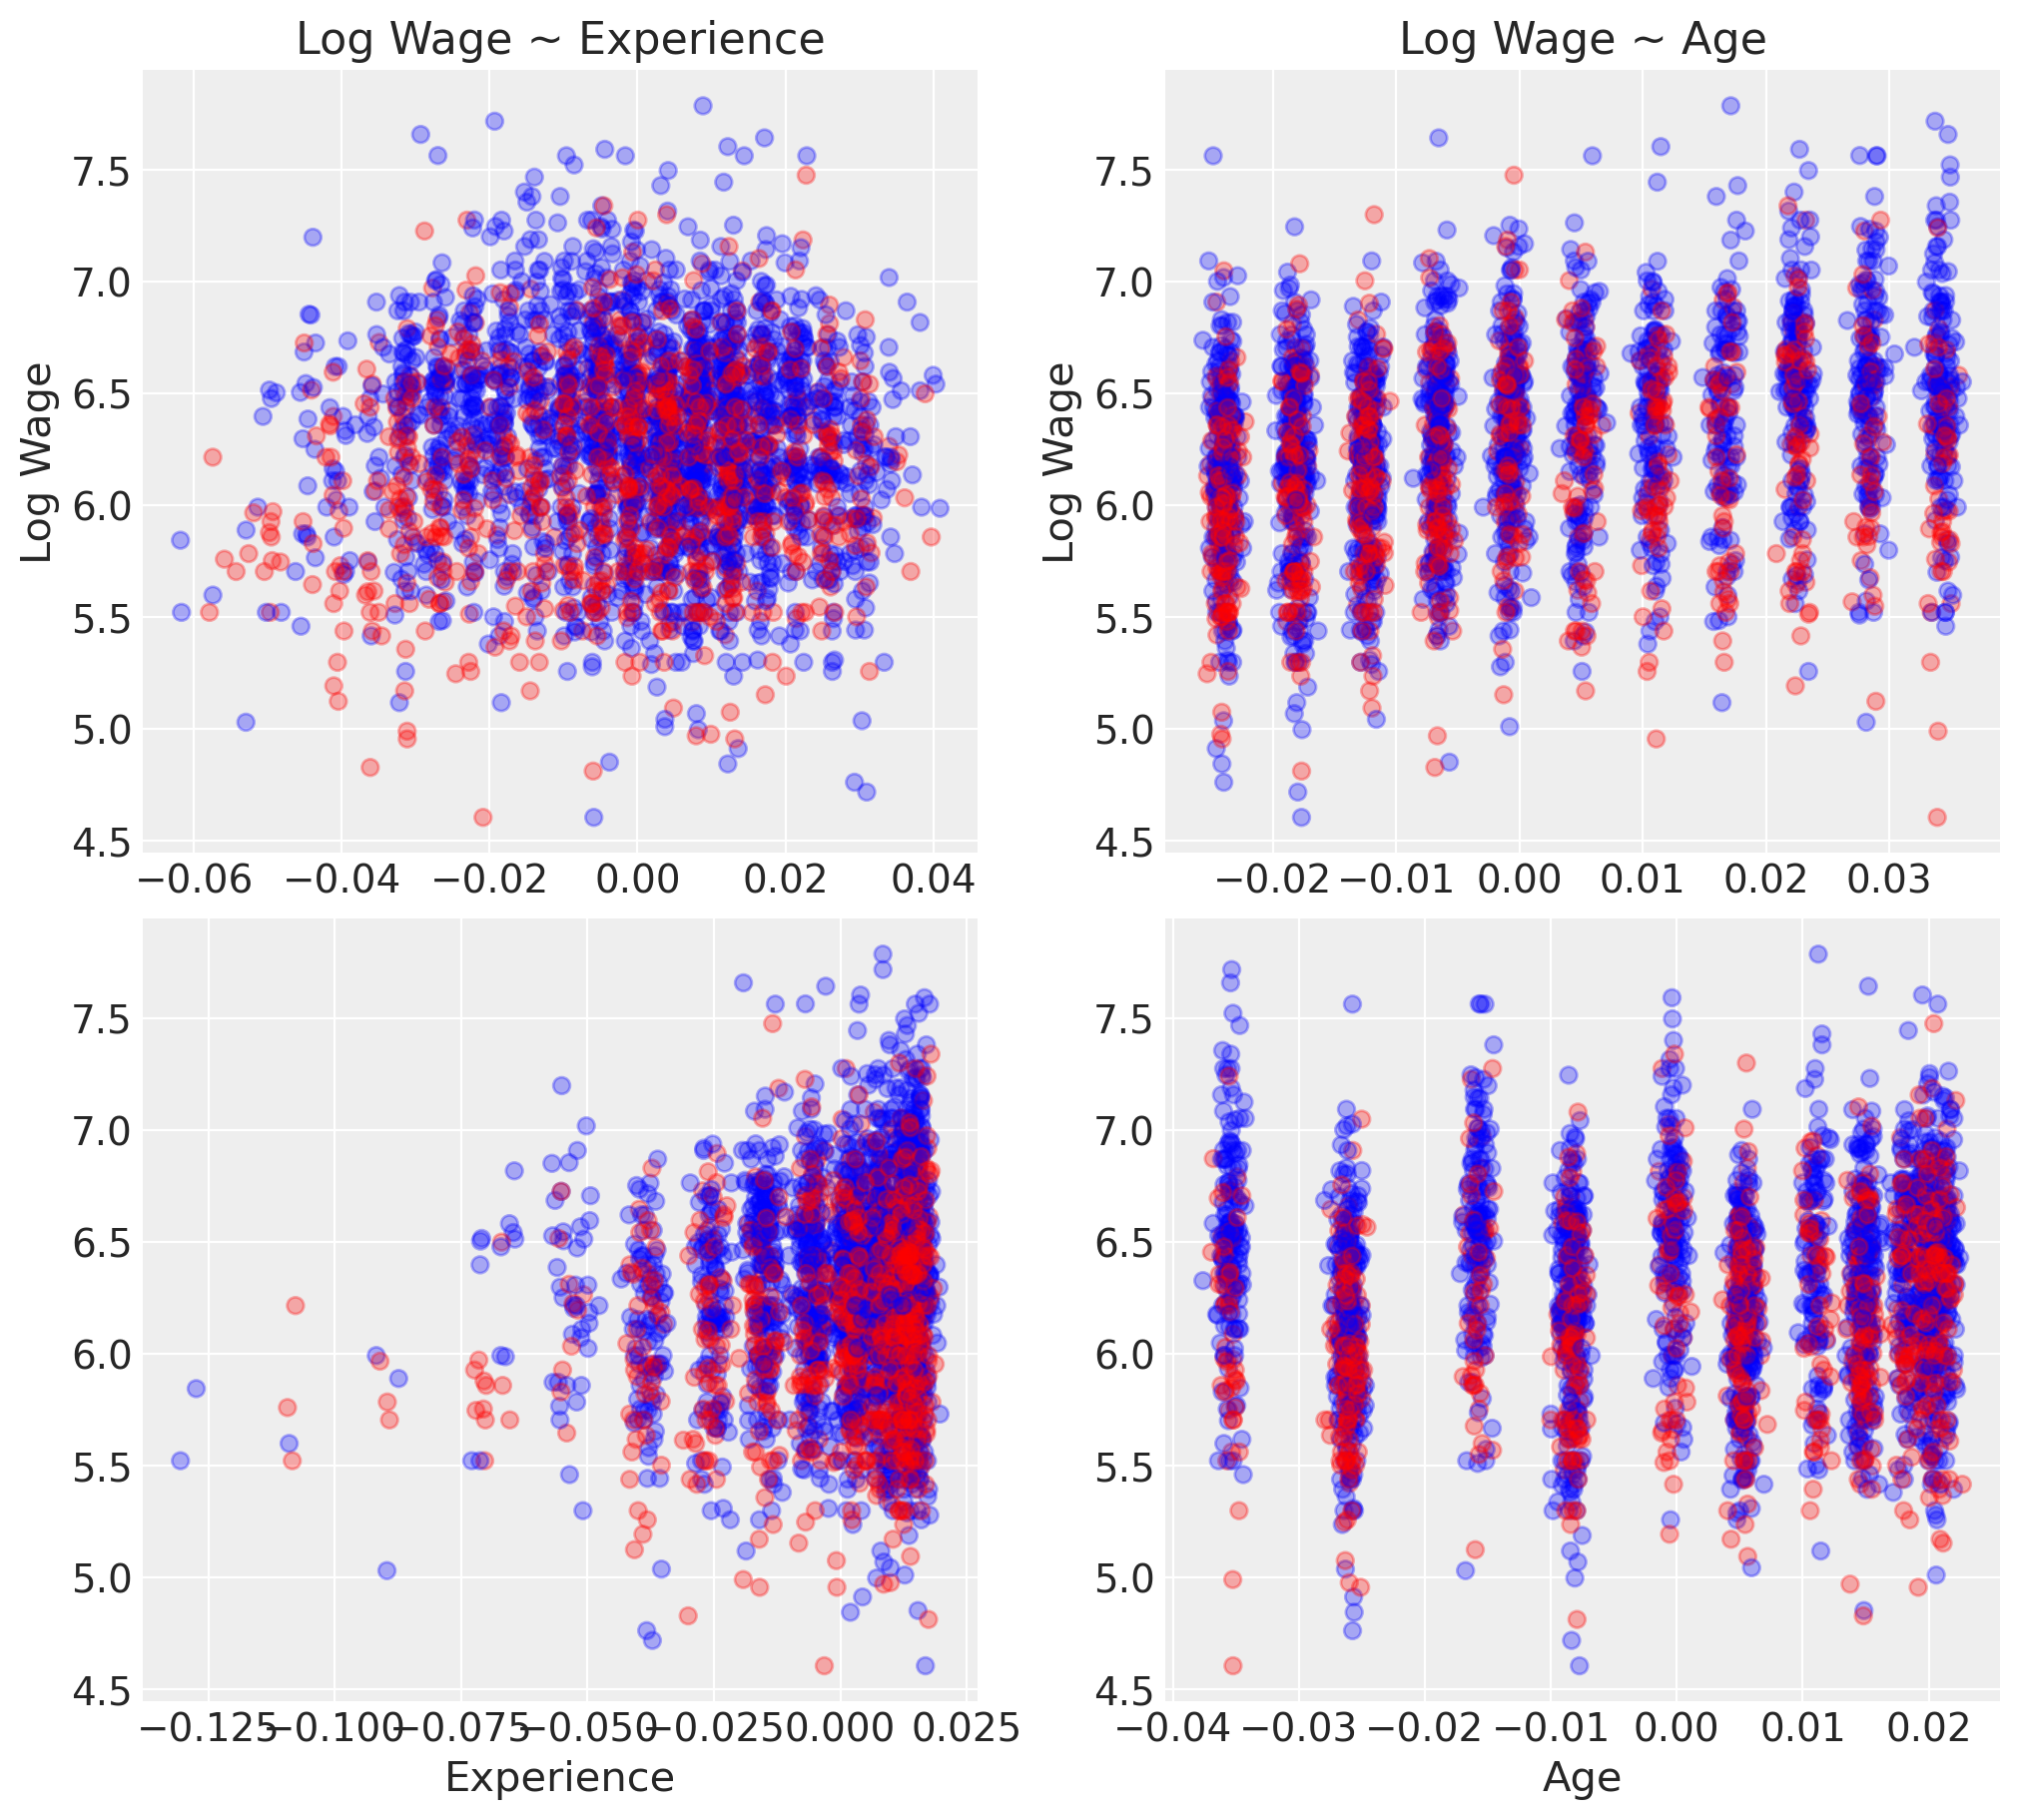

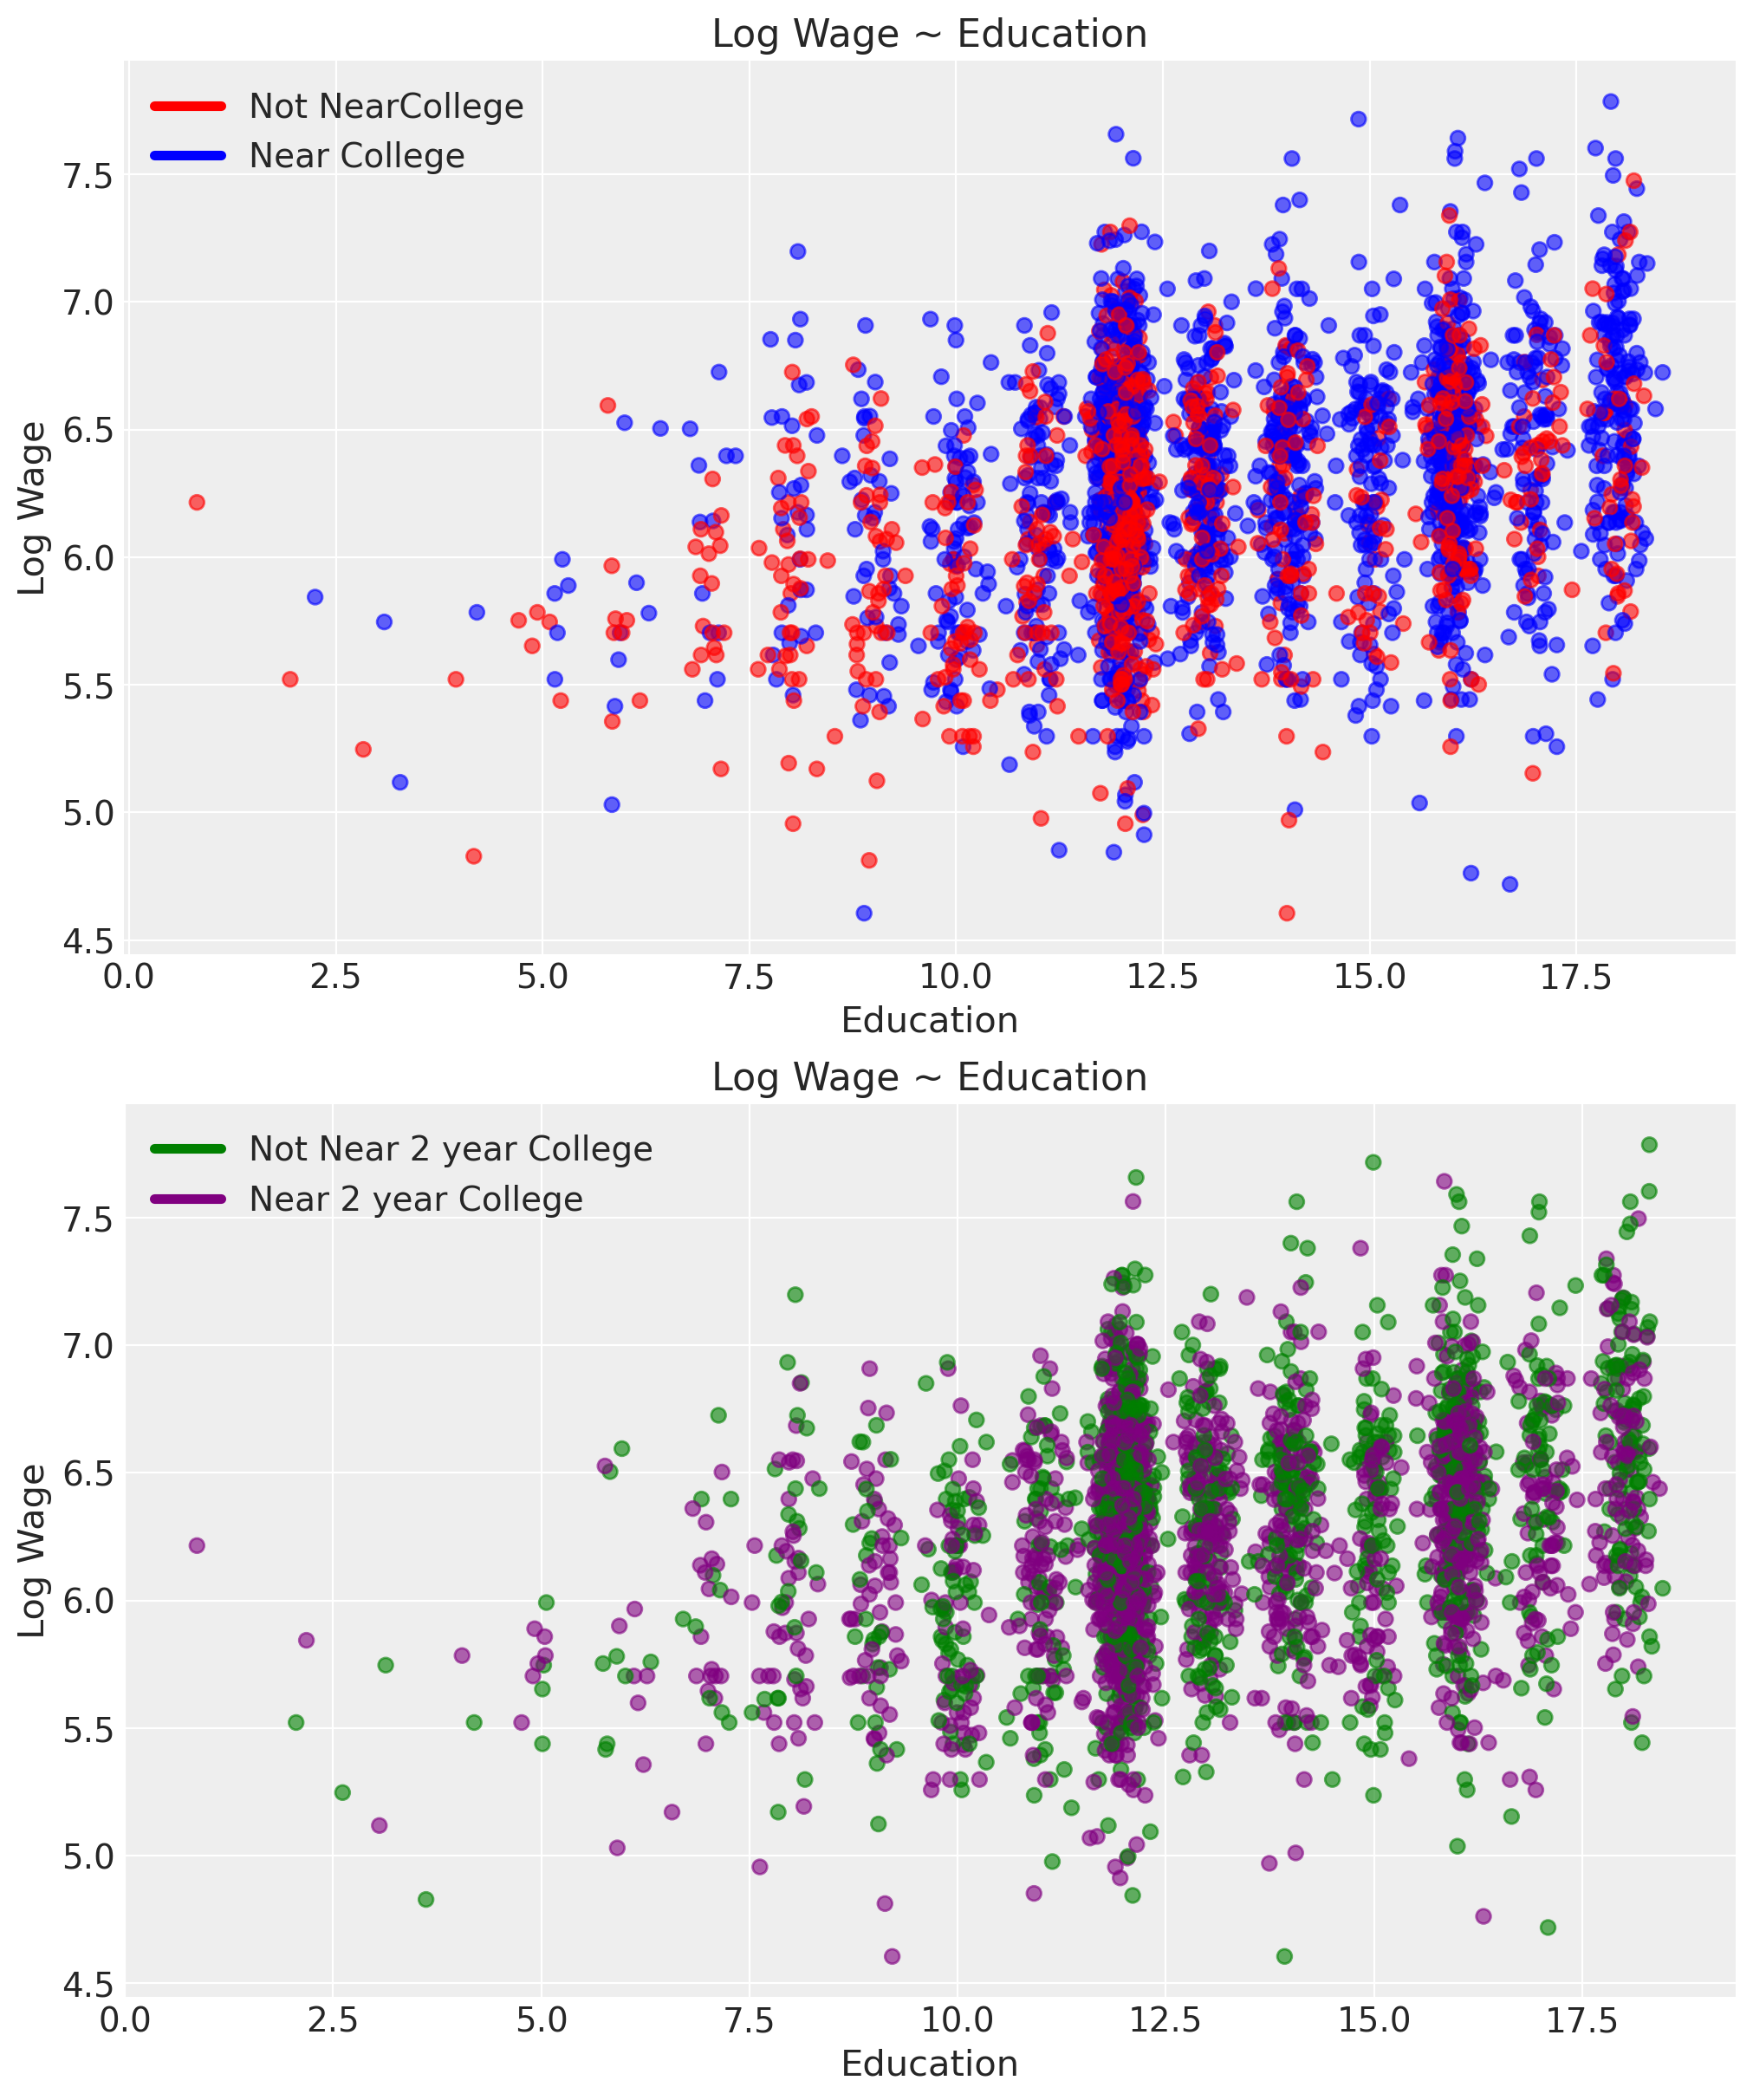

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 9))


def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev


col = np.where(df.nearcollege_indicator,'b','r')
axs = axs.flatten()
axs[0].scatter(rand_jitter(df['experience_1']), df['log_wage'], c=col, alpha=0.3)
axs[2].scatter(rand_jitter(df['experience_2']), df['log_wage'], c=col, alpha=0.3)
axs[2].set_xlabel("Experience")
axs[1].scatter(rand_jitter(df['age_1']), df['log_wage'], c=col, alpha=0.3)
axs[3].scatter(rand_jitter(df['age_2']), df['log_wage'], c=col, alpha=0.3)
axs[3].set_xlabel("Age")
axs[0].set_title("Log Wage ~ Experience")
axs[1].set_title("Log Wage ~ Age")
axs[0].set_ylabel("Log Wage")
axs[1].set_ylabel("Log Wage")


custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4)]


fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs  = axs.flatten()
ax = axs[0]
ax1 = axs[1]
ax.set_title("Log Wage ~ Education")
col = np.where(df.nearcollege_indicator,'b','r')
ax.scatter(rand_jitter(df['education']), df['log_wage'], c=col, alpha=0.6)
ax.legend(custom_lines, ['Not NearCollege', 'Near College'])
ax.set_xlabel("Education")
ax.set_ylabel("Log Wage")

custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='purple', lw=4)]
ax1.set_title("Log Wage ~ Education")
col = np.where(df.nearcollege2_indicator,'g','purple')
ax1.scatter(rand_jitter(df['education']), df['log_wage'], c=col, alpha=0.6)
ax1.legend(custom_lines, ['Not Near 2 year College', 'Near 2 year College'])
ax1.set_xlabel("Education")
ax1.set_ylabel("Log Wage");

There is at least some indication here that the proximity to college has an impact on education achieved and that education seems to drive upward the achieved wages. Typical approaches to instrumental variable regressions try to quantify the strength of the instrument formally. 

### Justificatory Models

We start with the simple regression context. This serves two purposes: (i) we can explore and how the effect of `education` is measured in a simple regression and we can (ii) benchmark the efficacy of our instrument `nearcollege_indcator` in the context of trying to predict `education`. These regressions are effectively diagnostic tests of our instrument. 

#### The First Stage

By fitting the first stage regression we can evaluate the __relevance__ assumption. This assumption is testable in that we want to be sure that the coefficient weight accorded to our instrument is not 0, and thereby show that the inclusion of the instrument can help predict some of the variance in the treatment. It is standard to include a F-test style check to help argue that your instrument indeed warrants being included in your understanding of the treatment. We show how perform this exercise below. 

In [7]:
covariate_df = df[["experience_1", "experience_2", "ethnicity_indicator", "smsa_indicator", 
                   "south_indicator", "nearcollege_indicator"]].copy()
covariate_df['Intercept'] = 1
covariate_df = covariate_df[["Intercept", "experience_1", "experience_2", "ethnicity_indicator", "smsa_indicator", 
                   "south_indicator", "nearcollege_indicator"]]


def make_reg_model(covariate_df, target='log_wage', prior_beta=[0, 1]):
    coords = {'covariates': list(covariate_df.columns)}
    with pm.Model(coords=coords) as reg_model:
        X = pm.MutableData('X', covariate_df)
        beta = pm.Normal('beta_z', prior_beta[0], prior_beta[1], dims='covariates')
        mu = pm.Deterministic('mu', pm.math.dot(X, beta))
        sigma = pm.TruncatedNormal("sigma", 1, lower=0.005)
        _ = pm.Normal('likelihood', mu, sigma, observed=df[target].values)
        idata_reg = pm.sample_prior_predictive()
        idata_reg.extend(pm.sample(nuts_sampler='numpyro', 
                                   target_accept=.99, 
                                   idata_kwargs = {'log_likelihood': True}))  ## requires Jax and Numpyro install
    return reg_model, idata_reg


first_stage_model, idata_first_stage = make_reg_model(covariate_df, target='education')
second_stage_model, idata_second_stage = make_reg_model(covariate_df, target='log_wage')

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We can now pull out the parameter estimates for our first stage model which shows a positive beta coefficient indicating that our instrument is indeed useful in predicting the `education` metric. 

In [8]:
az.summary(idata_first_stage, var_names=['beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              12.830  0.109  12.643   13.048    1.0
beta_z[experience_1]           13.045  0.984  11.252   14.898    1.0
beta_z[experience_2]           -0.192  0.916  -1.974    1.470    1.0
beta_z[ethnicity_indicator]    -1.367  0.107  -1.556   -1.162    1.0
beta_z[smsa_indicator]          0.849  0.105   0.646    1.037    1.0
beta_z[south_indicator]        -0.368  0.097  -0.543   -0.184    1.0
beta_z[nearcollege_indicator]   0.397  0.100   0.200    0.573    1.0

Here we apply F-test style logic to evaluate the proportion of variance explained by our model differs from the intercept only (or null model). This test arises because We can reject the null whenever the `F_stat` implied by our model is an extreme outlier on the F-distribution implied by our null-hypothesis. 

In [9]:
def make_F_test(idata, df, df_mod = 6, df_res = 3003):
    covariates = list(idata['posterior']['beta_z']['covariates'].values)
    temp = df.copy()
    temp['Intercept'] = 1
    covariate_df = temp[covariates]
    params = az.extract(idata['posterior']['beta_z'])['beta_z']
    preds = np.dot(covariate_df, params.mean(axis=1))
    resids = df['education'] - preds
    ss_res = np.sum(np.square(resids))
    ## Intercept Only model
    ss_tot = np.sum((df['education'] - np.mean(df['education']))**2)
    ss_mod = ss_tot - ss_res
    ss_mod = ss_mod / df_mod
    ss_res = ss_res / df_res
    F_stat = ss_mod / ss_res
    p_value = np.round(scipy.stats.f.sf(F_stat, df_mod, df_res), 5)
    return F_stat, p_value


make_F_test(idata_first_stage, df)

(133.6707657833557, 0.0)

Here we can reject the null at any level. There have been various thresholds put forward in the literature based on simulation studies for when we should deem an instrument "strong" enough, but these are crude rules of thumb and should not be relied on to defend your design. We want to justify our instrument theoretically and ensure that it is well-identified in the first stage regression. In the Bayesian setting we want to know how the prior/posterior update step has shifted our distribution.

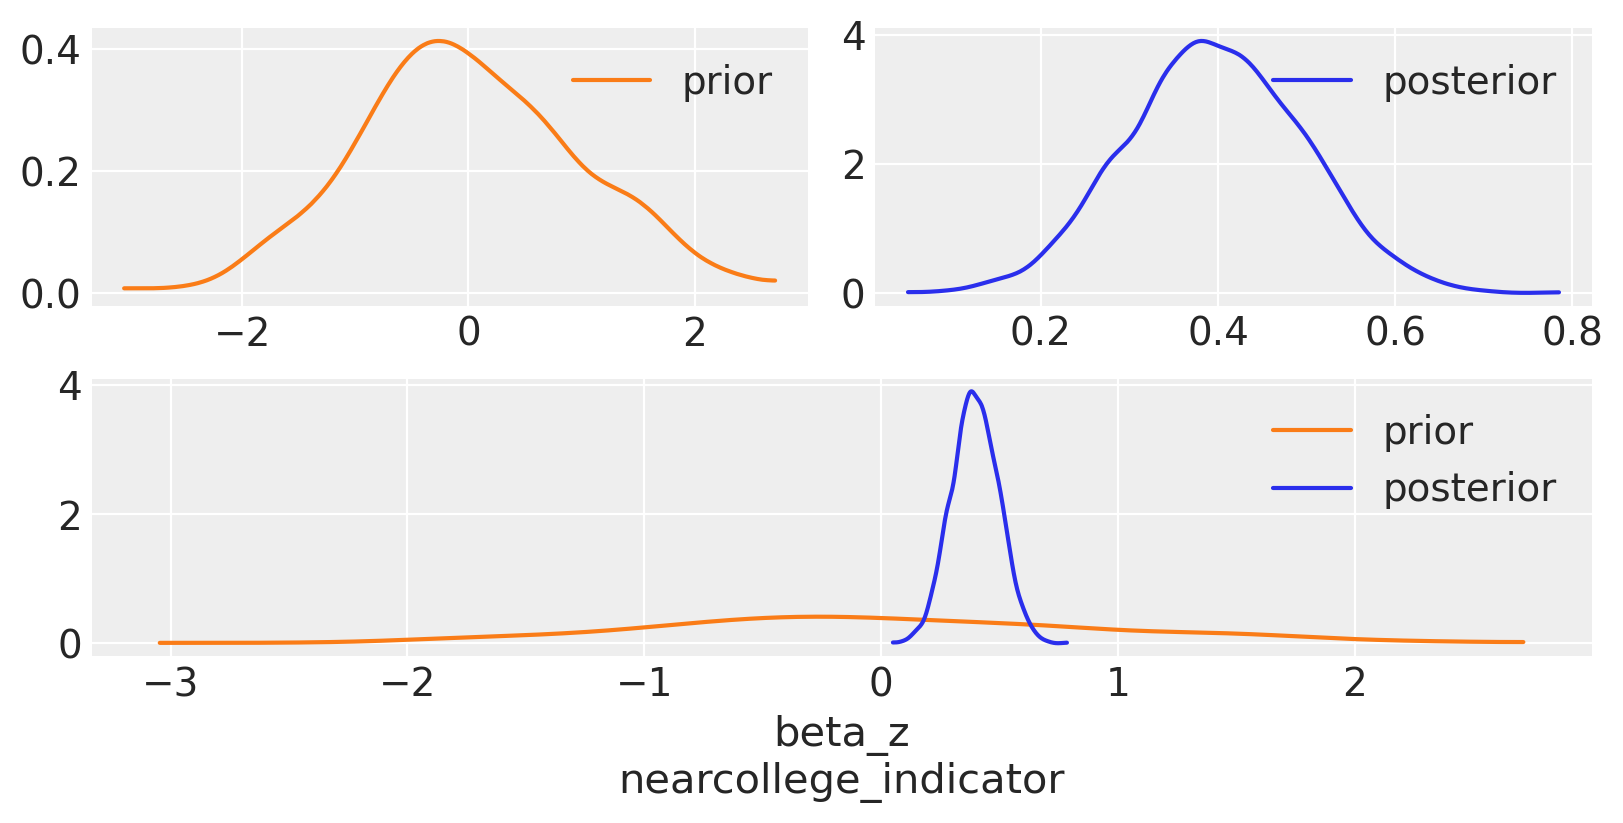

In [10]:
az.plot_dist_comparison(idata_first_stage, var_names=['beta_z'], coords={'covariates': ['nearcollege_indicator']},
                        figsize=(8, 4));

### The Second Stage

While in the case of __relevance__ we can aim to justify our assumptions as above, but with the __exclusion restriction__ assumption we cannot directly test the claim. Remember we're arguing that the influence of our instrument $Z$ impacts our outcome $Y$ only through the treatment $T$. In our case this means that the exclusion restriction assumption would be violated if proximity to college had an impact on earnings independent of the mediating effect of schooling. This is presumably not impossible, but all counterexamples that I can think of have the feel of edge-cases that will ideally filter into irrelevance with a sufficiently large data set.  

In [11]:
az.summary(idata_second_stage['posterior']['beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              6.218  0.018   6.186    6.253    1.0
beta_z[experience_1]          -1.962  0.383  -2.728   -1.286    1.0
beta_z[experience_2]           2.217  0.377   1.506    2.942    1.0
beta_z[ethnicity_indicator]   -0.262  0.019  -0.299   -0.230    1.0
beta_z[smsa_indicator]         0.184  0.017   0.149    0.214    1.0
beta_z[south_indicator]       -0.143  0.016  -0.173   -0.113    1.0
beta_z[nearcollege_indicator]  0.046  0.017   0.012    0.076    1.0

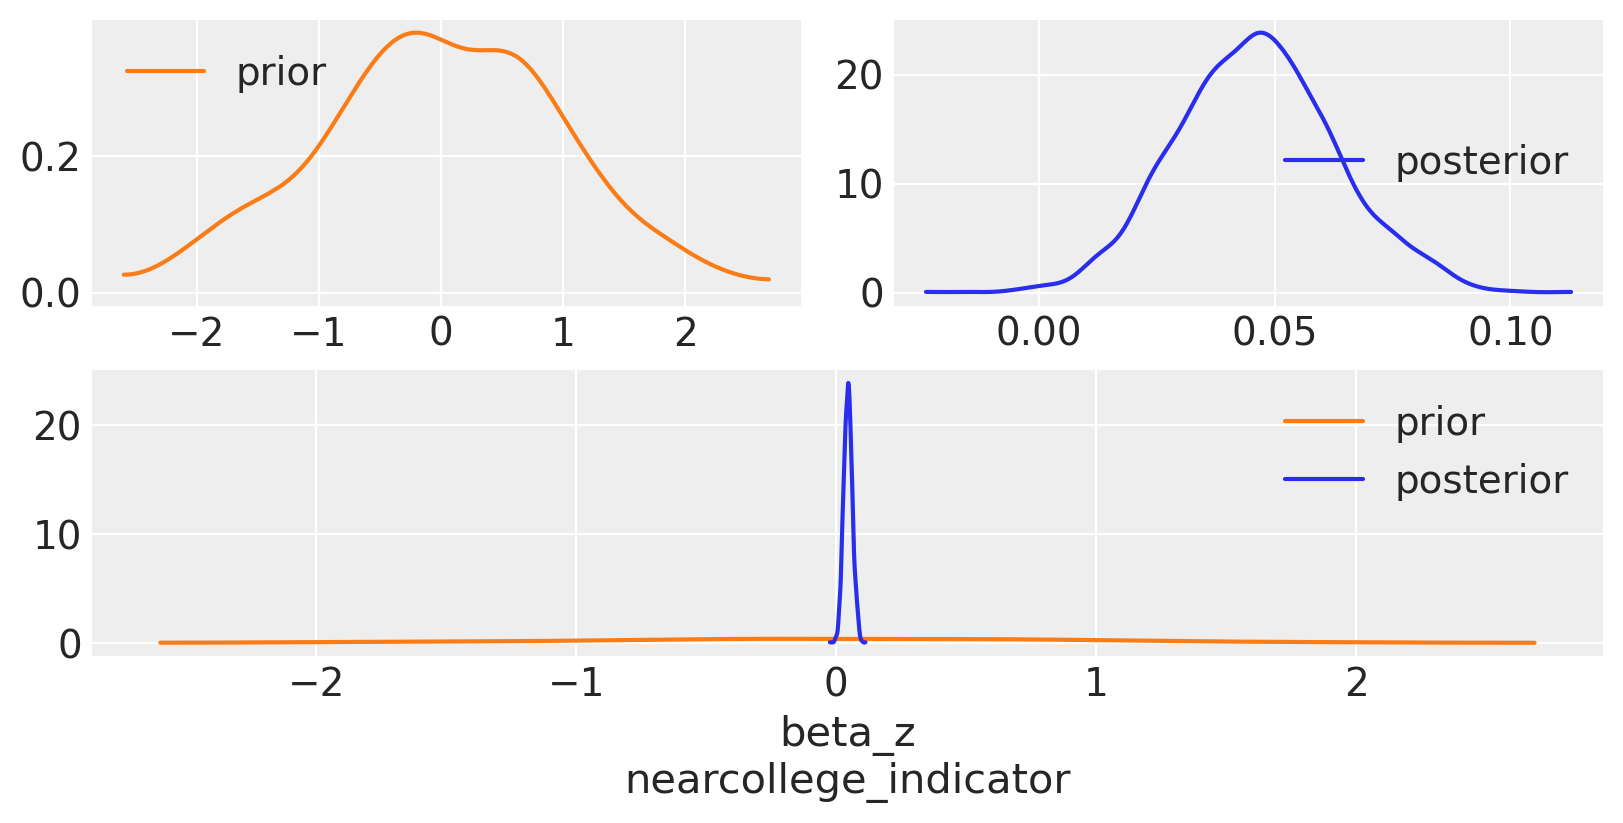

In [12]:
az.plot_dist_comparison(idata_second_stage, var_names=['beta_z'], coords={'covariates': ['nearcollege_indicator']},
                        figsize=(8, 4));

Here the second stage regression indicates a parameter estimate quite close to zero suggesting at least in the task of predicting log-wages we should see the predictive impact of proximity absorbed into the education variable.

### The Wald Estimate

These exploratory regressions give us an understanding of the dynamics at play in an instrumental variable set up, but we also get (for free) a means of calculating the LATE quantity by means of the Wald estimation routine. 

In [13]:
second = az.extract(idata_second_stage['posterior'])['beta_z'].sel(covariates='nearcollege_indicator') 
first = az.extract(idata_first_stage['posterior'])['beta_z'].sel(covariates='nearcollege_indicator')
estimate = second / first
estimate.mean()

<xarray.DataArray 'beta_z' ()> Size: 8B
array(0.12511965)
Coordinates:
    covariates  <U21 84B 'nearcollege_indicator'

Which is to say that the Wald estimate implies 0.12 in the log-wage for an additional year in education. We'll translate this to the raw outcome scale below.  

### Wald Estimate Versus Simple Controlling Regression

But now we can compare this estimate to the regression achieved with a simpler regression that just includes `education` as a control. 

In [14]:
naive_reg_model, idata_reg = make_reg_model(covariate_df.assign(education = df['education']))
az.summary(idata_reg, var_names=['beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              5.347  0.047   5.261    5.436    1.0
beta_z[experience_1]          -7.210  0.454  -8.026   -6.327    1.0
beta_z[experience_2]           2.321  0.348   1.679    2.978    1.0
beta_z[ethnicity_indicator]   -0.191  0.018  -0.224   -0.158    1.0
beta_z[smsa_indicator]         0.154  0.016   0.123    0.183    1.0
beta_z[south_indicator]       -0.122  0.015  -0.150   -0.093    1.0
beta_z[nearcollege_indicator]  0.023  0.016  -0.006    0.053    1.0
beta_z[education]              0.067  0.003   0.060    0.073    1.0

Here we see how a regression which includes our instrument and our treatment sees coefficient accorded to our instrument shrink further towards 0. This is somewhat suggestive that the __exclusion restriction__ remains plausible. 

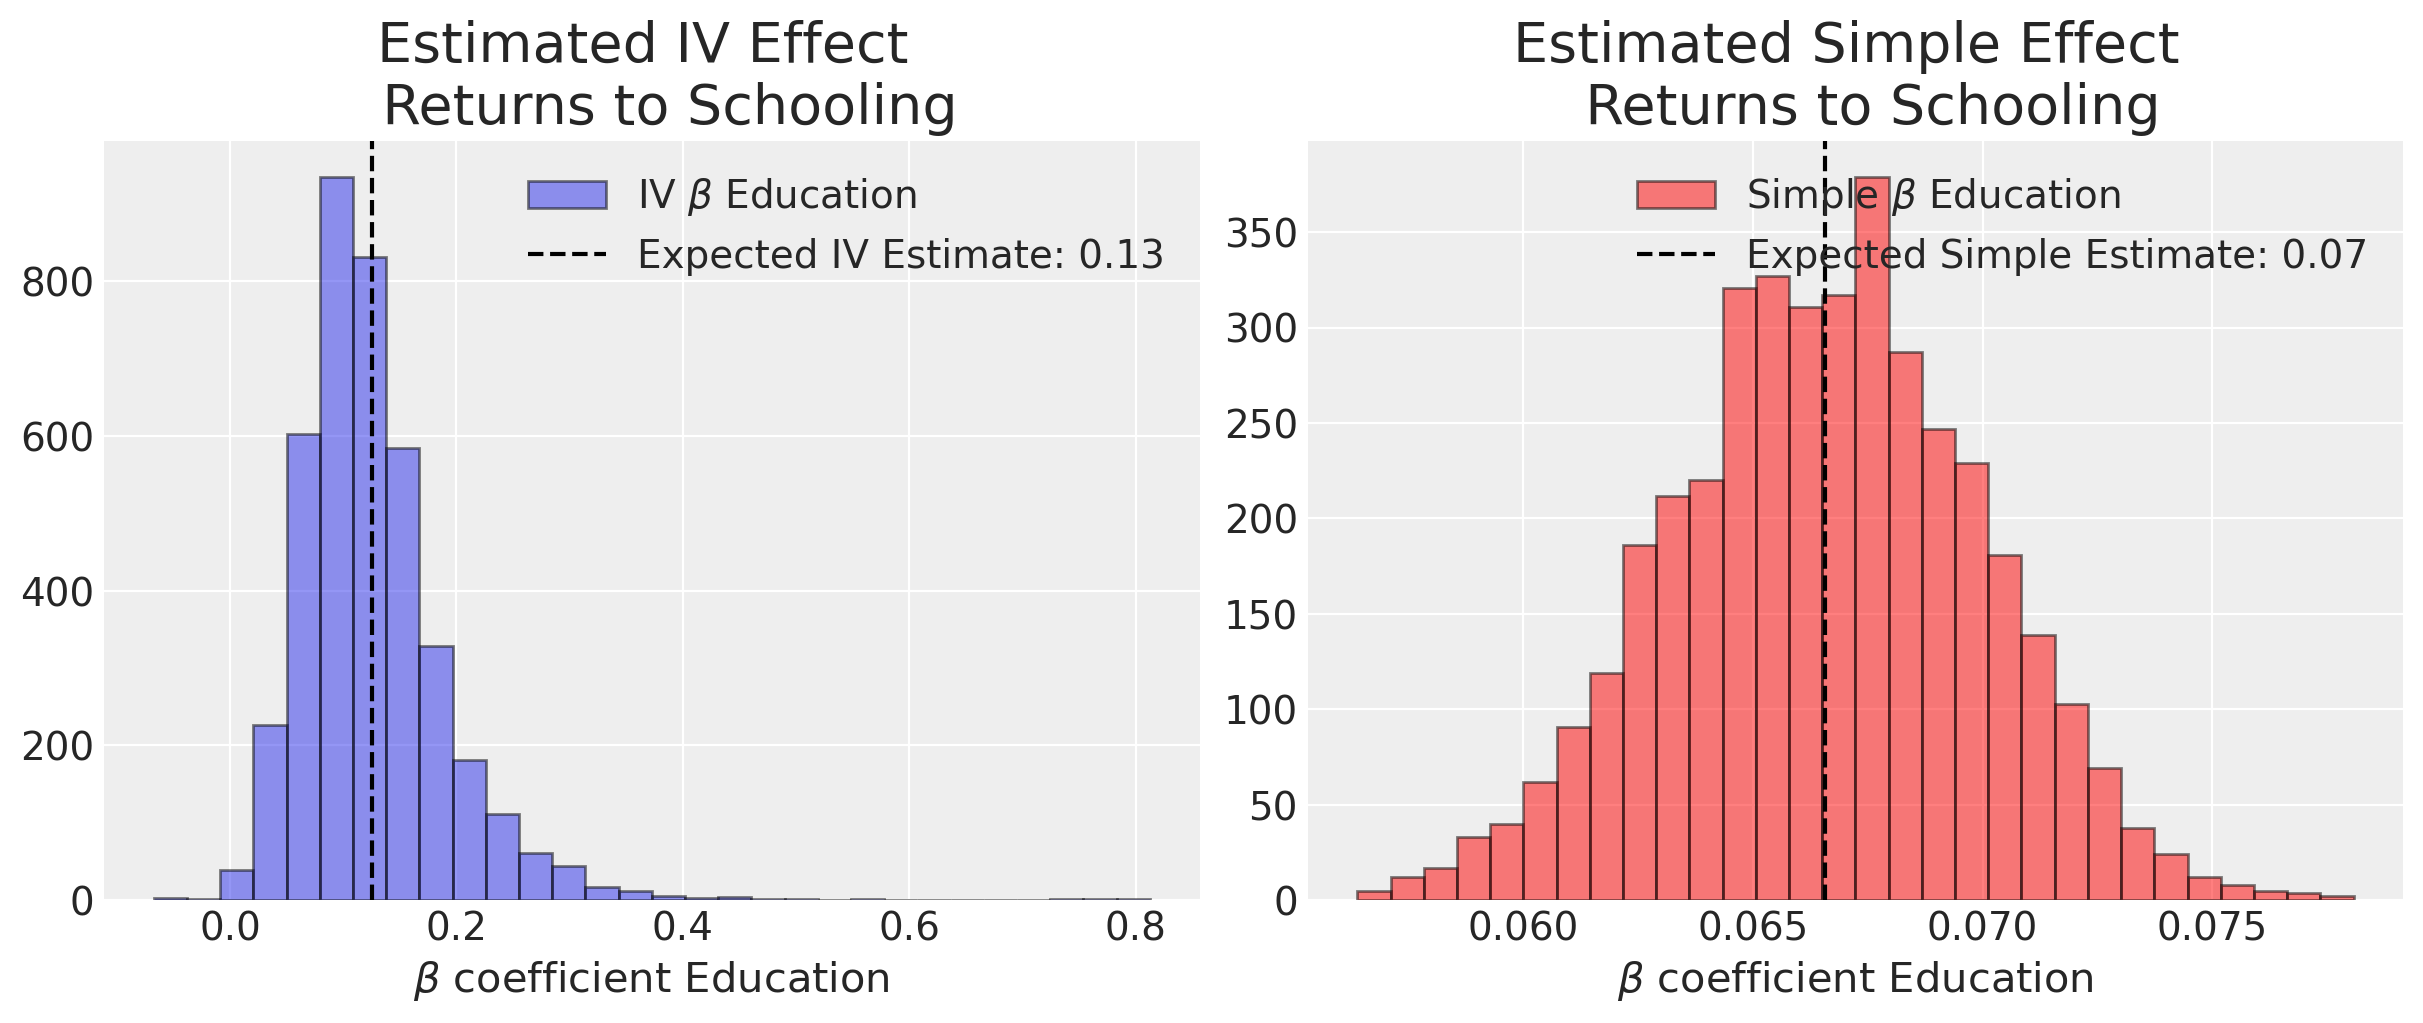

In [15]:
ols_estimate = az.extract(idata_reg['posterior'])['beta_z'].sel(covariates='education')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
ax.hist(estimate, bins=30, ec='black', alpha=0.5, label=r'IV $\beta$ Education')
ax1.hist(ols_estimate, bins=30, ec='black', alpha=0.5, label=r'Simple $\beta$ Education', color='red')
ax.axvline(np.mean(estimate), linestyle='--', color='k', label=f'Expected IV Estimate: {np.round(np.mean(estimate.values), 2)}')
ax1.axvline(np.mean(ols_estimate), linestyle='--', color='k', label=f'Expected Simple Estimate: {np.round(np.mean(ols_estimate.values), 2)}')
ax.set_xlabel(r"$\beta$ coefficient Education")
ax1.set_xlabel(r"$\beta$ coefficient Education")

ax.legend()
ax1.legend()
ax.set_title("Estimated IV Effect \n  Returns to Schooling", fontsize=20)
ax1.set_title("Estimated Simple Effect \n  Returns to Schooling", fontsize=20);

Note here the marked difference in magnitude between the naive regression and the instrumental variable estimates. 

### CausalPy and Multivariate Models

Now we fit the models using CausalPy's Bayesian instrumental variable regression.

In [16]:
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "progressbar": True, 
    "nuts_sampler": 'numpyro',  ## requires Jax and Numpyro install
    "idata_kwargs" : {'log_likelihood': True}
}
instruments_formula = "education ~ 1 + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator + nearcollege_indicator"
formula = "log_wage ~ 1 + education  + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator"
instruments_data = df[["education", "nearcollege_indicator", "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]
data = df[["log_wage", "education",  "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]
iv = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)

az.summary(iv.idata, var_names=['beta_t', 'beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/nathanielforde/Documents/Github/CausalPy/causalpy/data_validation.py:143: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2B92DD7E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [likelihood]


Output()

mean     sd  hdi_3%  hdi_97%  r_hat
beta_t[Intercept]              13.095  0.089  12.929   13.259   1.00
beta_t[experience_1]           89.853  0.909  88.074   91.516   1.00
beta_t[experience_2]           -0.852  0.882  -2.498    0.750   1.00
beta_t[ethnicity_indicator]    -1.008  0.090  -1.169   -0.836   1.00
beta_t[south_indicator]        -0.288  0.079  -0.425   -0.129   1.00
beta_t[smsa_indicator]          0.406  0.085   0.244    0.563   1.00
beta_t[nearcollege_indicator]   0.337  0.081   0.185    0.491   1.00
beta_z[Intercept]               4.494  0.151   4.183    4.749   1.01
beta_z[education]               0.132  0.011   0.111    0.154   1.00
beta_z[experience_1]          -14.134  0.953 -15.947  -12.399   1.00
beta_z[experience_2]            2.689  0.349   2.003    3.317   1.00
beta_z[ethnicity_indicator]    -0.131  0.022  -0.171   -0.091   1.00
beta_z[south_indicator]        -0.105  0.016  -0.137   -0.075   1.00
beta_z[smsa_indicator]          0.131  0.017   0.099    0.164   1.00

In [17]:
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "progressbar": False, 
    "nuts_sampler": 'numpyro', ## requires Jax and Numpyro install
    "idata_kwargs" : {'log_likelihood': True}
}
instruments_formula = """education ~  experience_1 + experience_2 + ethnicity_indicator + south_indicator + 
                                      smsa_indicator + nearcollege_indicator + nearcollege2_indicator"""

formula = "log_wage ~ 1 + education  + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator"

instruments_data = df[["education", "nearcollege_indicator", "nearcollege2_indicator", 
                       "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]

data = df[["log_wage", "education",  "experience_1" ,"experience_2",  "ethnicity_indicator", 
           "smsa_indicator", "south_indicator"]]
iv1 = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)

az.summary(iv1.idata, var_names=['beta_t', 'beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/nathanielforde/Documents/Github/CausalPy/causalpy/data_validation.py:143: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2B8525700>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [likelihood]


Output()

mean     sd  hdi_3%  hdi_97%  r_hat
beta_t[Intercept]               13.058  0.091  12.892   13.231    1.0
beta_t[experience_1]            89.911  0.888  88.283   91.584    1.0
beta_t[experience_2]            -0.793  0.879  -2.472    0.817    1.0
beta_t[ethnicity_indicator]     -1.017  0.091  -1.203   -0.861    1.0
beta_t[south_indicator]         -0.276  0.080  -0.428   -0.133    1.0
beta_t[smsa_indicator]           0.389  0.085   0.228    0.545    1.0
beta_t[nearcollege_indicator]    0.308  0.077   0.170    0.457    1.0
beta_t[nearcollege2_indicator]   0.154  0.068   0.037    0.292    1.0
beta_z[Intercept]                4.108  0.149   3.826    4.374    1.0
beta_z[education]                0.161  0.011   0.141    0.183    1.0
beta_z[experience_1]           -16.731  0.943 -18.454  -14.970    1.0
beta_z[experience_2]             2.715  0.357   2.068    3.392    1.0
beta_z[ethnicity_indicator]     -0.102  0.023  -0.142   -0.056    1.0
beta_z[south_indicator]         -0.095  0.017  -0.128   -0.064    1.0
beta_z[smsa_indicator]           0.117  0.018   0.082    0.148    1.0

### Sensitivity Checks


In [18]:
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "progressbar": True, 
    "nuts_sampler": 'numpyro',  ## requires Jax and Numpyro install
    "idata_kwargs" : {'log_likelihood': True}
}
instruments_formula = """education ~ experience_1 + experience_2 + ethnicity_indicator + south_indicator + 
                                      smsa_indicator + nearcollege_indicator
                                      """
formula = "log_wage ~ 1 + education + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator"
instruments_data = df[["education", "nearcollege_indicator",
                       "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]
data = df[["log_wage", "education",  "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]

scaler = StandardScaler()
data['experience_1'] = scaler.fit_transform(data[['experience_1']])
instruments_data['experience_1'] = scaler.fit_transform(instruments_data[['experience_1']])
data

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_33379/1577127045.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['experience_1'] = scaler.fit_transform(data[['experience_1']])
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_33379/1577127045.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instruments_data['experience_1'] = scaler.fit_transform(instruments_data[['experience_1']])


log_wage  education  experience_1  experience_2  ethnicity_indicator  \
0     6.306275          7     -1.725159     -0.016329                    1   
1     6.175867         12     -0.034739      0.014776                    0   
2     6.580639         12     -1.725159     -0.016329                    0   
3     5.521461         11     -0.276228      0.015422                    0   
4     6.591674         12     -1.725159     -0.016329                    0   
...        ...        ...           ...           ...                  ...   
3005  5.814131         12      0.448238      0.008397                    0   
3006  6.175867         13     -1.483670     -0.006796                    0   
3007  6.214608         12      0.689727      0.002662                    0   
3008  6.569481         12     -1.000693      0.007180                    0   
3009  6.263398         13      0.448238      0.008397                    1   

      smsa_indicator  south_indicator  
0                  1                0  
1                  1                0  
2                  1                0  
3                  1                0  
4                  1                0  
...              ...              ...  
3005               0                1  
3006               1                1  
3007               0                1  
3008               0                1  
3009               0                1  

[3010 rows x 7 columns]

In [19]:
modified = iv.ols_beta_second_params
modified[1] = .20
modified[2] = 0
modified

[4.486489832009674,
 0.2,
 0,
 2.6929616114117123,
 -0.13080191375573674,
 -0.10490054155737207,
 0.13132367504470194]

In [20]:
modified_first = iv.ols_beta_first_params
modified_first[1] = 0
modified_first

[13.098074632594448,
 0,
 -0.8633797925737376,
 -1.0061382678610173,
 -0.29146401700569985,
 0.40387687667134015,
 0.33732078008876376]

In [21]:
iv2 = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    priors = {"mus": [modified_first, modified], "sigmas": [1, 1],
                      "eta": 10, "lkj_sd": 2}
)

az.summary(iv2.idata, var_names=['beta_t', 'beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/nathanielforde/Documents/Github/CausalPy/causalpy/data_validation.py:143: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2BCE66F80>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [likelihood]


Output()

mean     sd  hdi_3%  hdi_97%  r_hat
beta_t[Intercept]              13.097  0.087  12.933   13.257   1.00
beta_t[experience_1]            1.636  0.037   1.566    1.703   1.00
beta_t[experience_2]           -0.864  0.852  -2.498    0.699   1.00
beta_t[ethnicity_indicator]    -1.009  0.088  -1.169   -0.844   1.00
beta_t[south_indicator]        -0.291  0.078  -0.442   -0.150   1.00
beta_t[smsa_indicator]          0.405  0.084   0.248    0.558   1.00
beta_t[nearcollege_indicator]   0.337  0.081   0.194    0.494   1.00
beta_z[Intercept]               4.829  0.426   4.039    5.653   1.01
beta_z[education]               0.106  0.032   0.044    0.166   1.01
beta_z[experience_1]           -0.216  0.053  -0.319   -0.116   1.01
beta_z[experience_2]            2.666  0.348   2.030    3.317   1.00
beta_z[ethnicity_indicator]    -0.157  0.037  -0.230   -0.091   1.01
beta_z[south_indicator]        -0.114  0.019  -0.148   -0.079   1.00
beta_z[smsa_indicator]          0.145  0.024   0.099    0.187   1.00

Sampling: [beta_z]


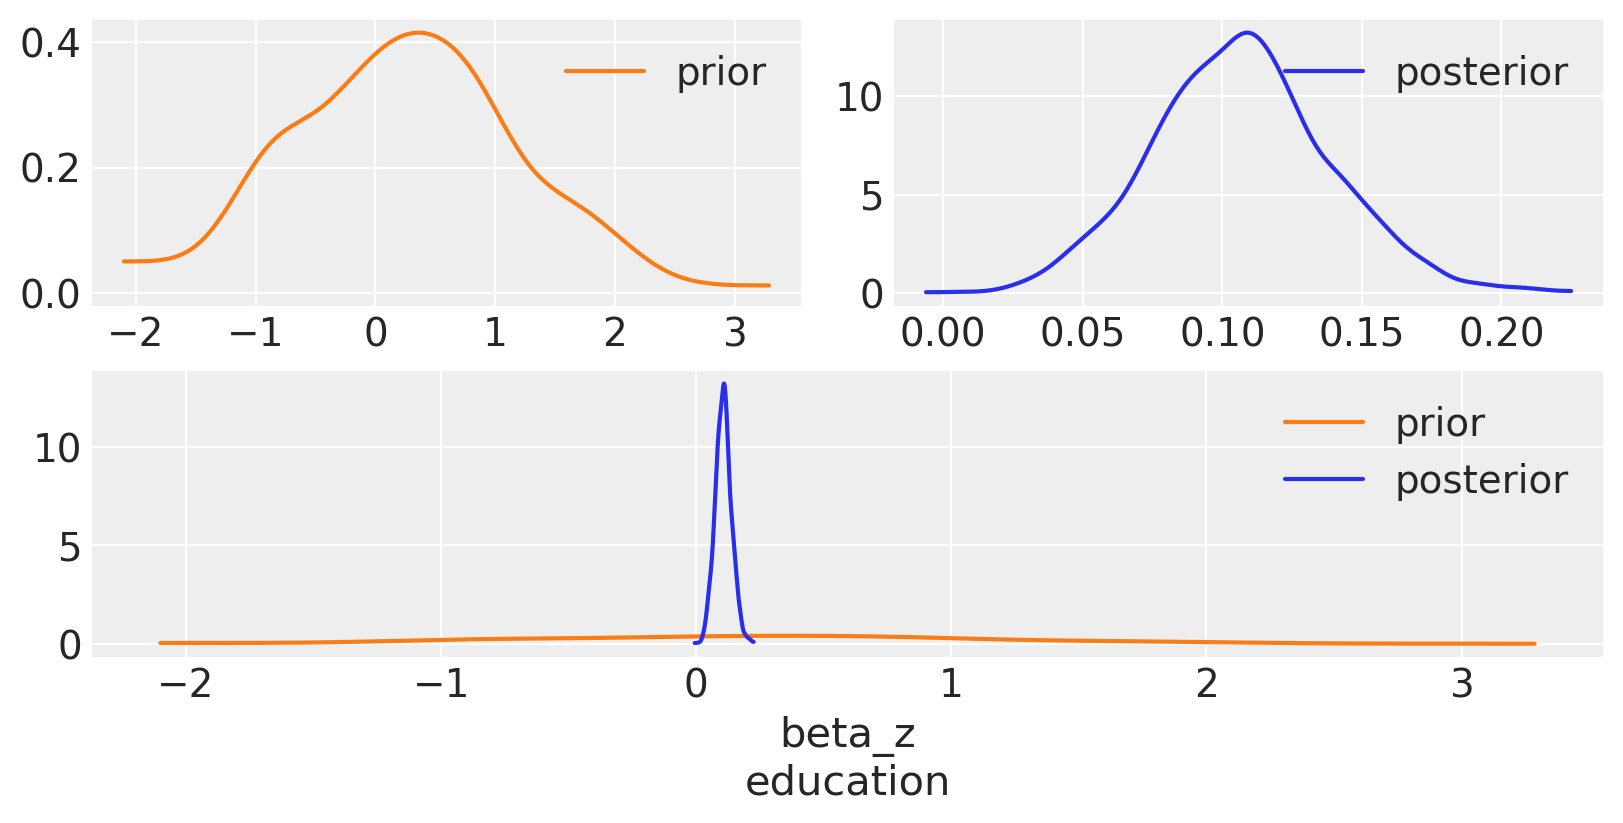

In [22]:
with iv2.model:
    iv2.idata.extend(pm.sample_prior_predictive(var_names=['beta_z']))
az.plot_dist_comparison(iv2.idata, var_names=['beta_z'], coords={'covariates': ['education']}, figsize=(8, 4));

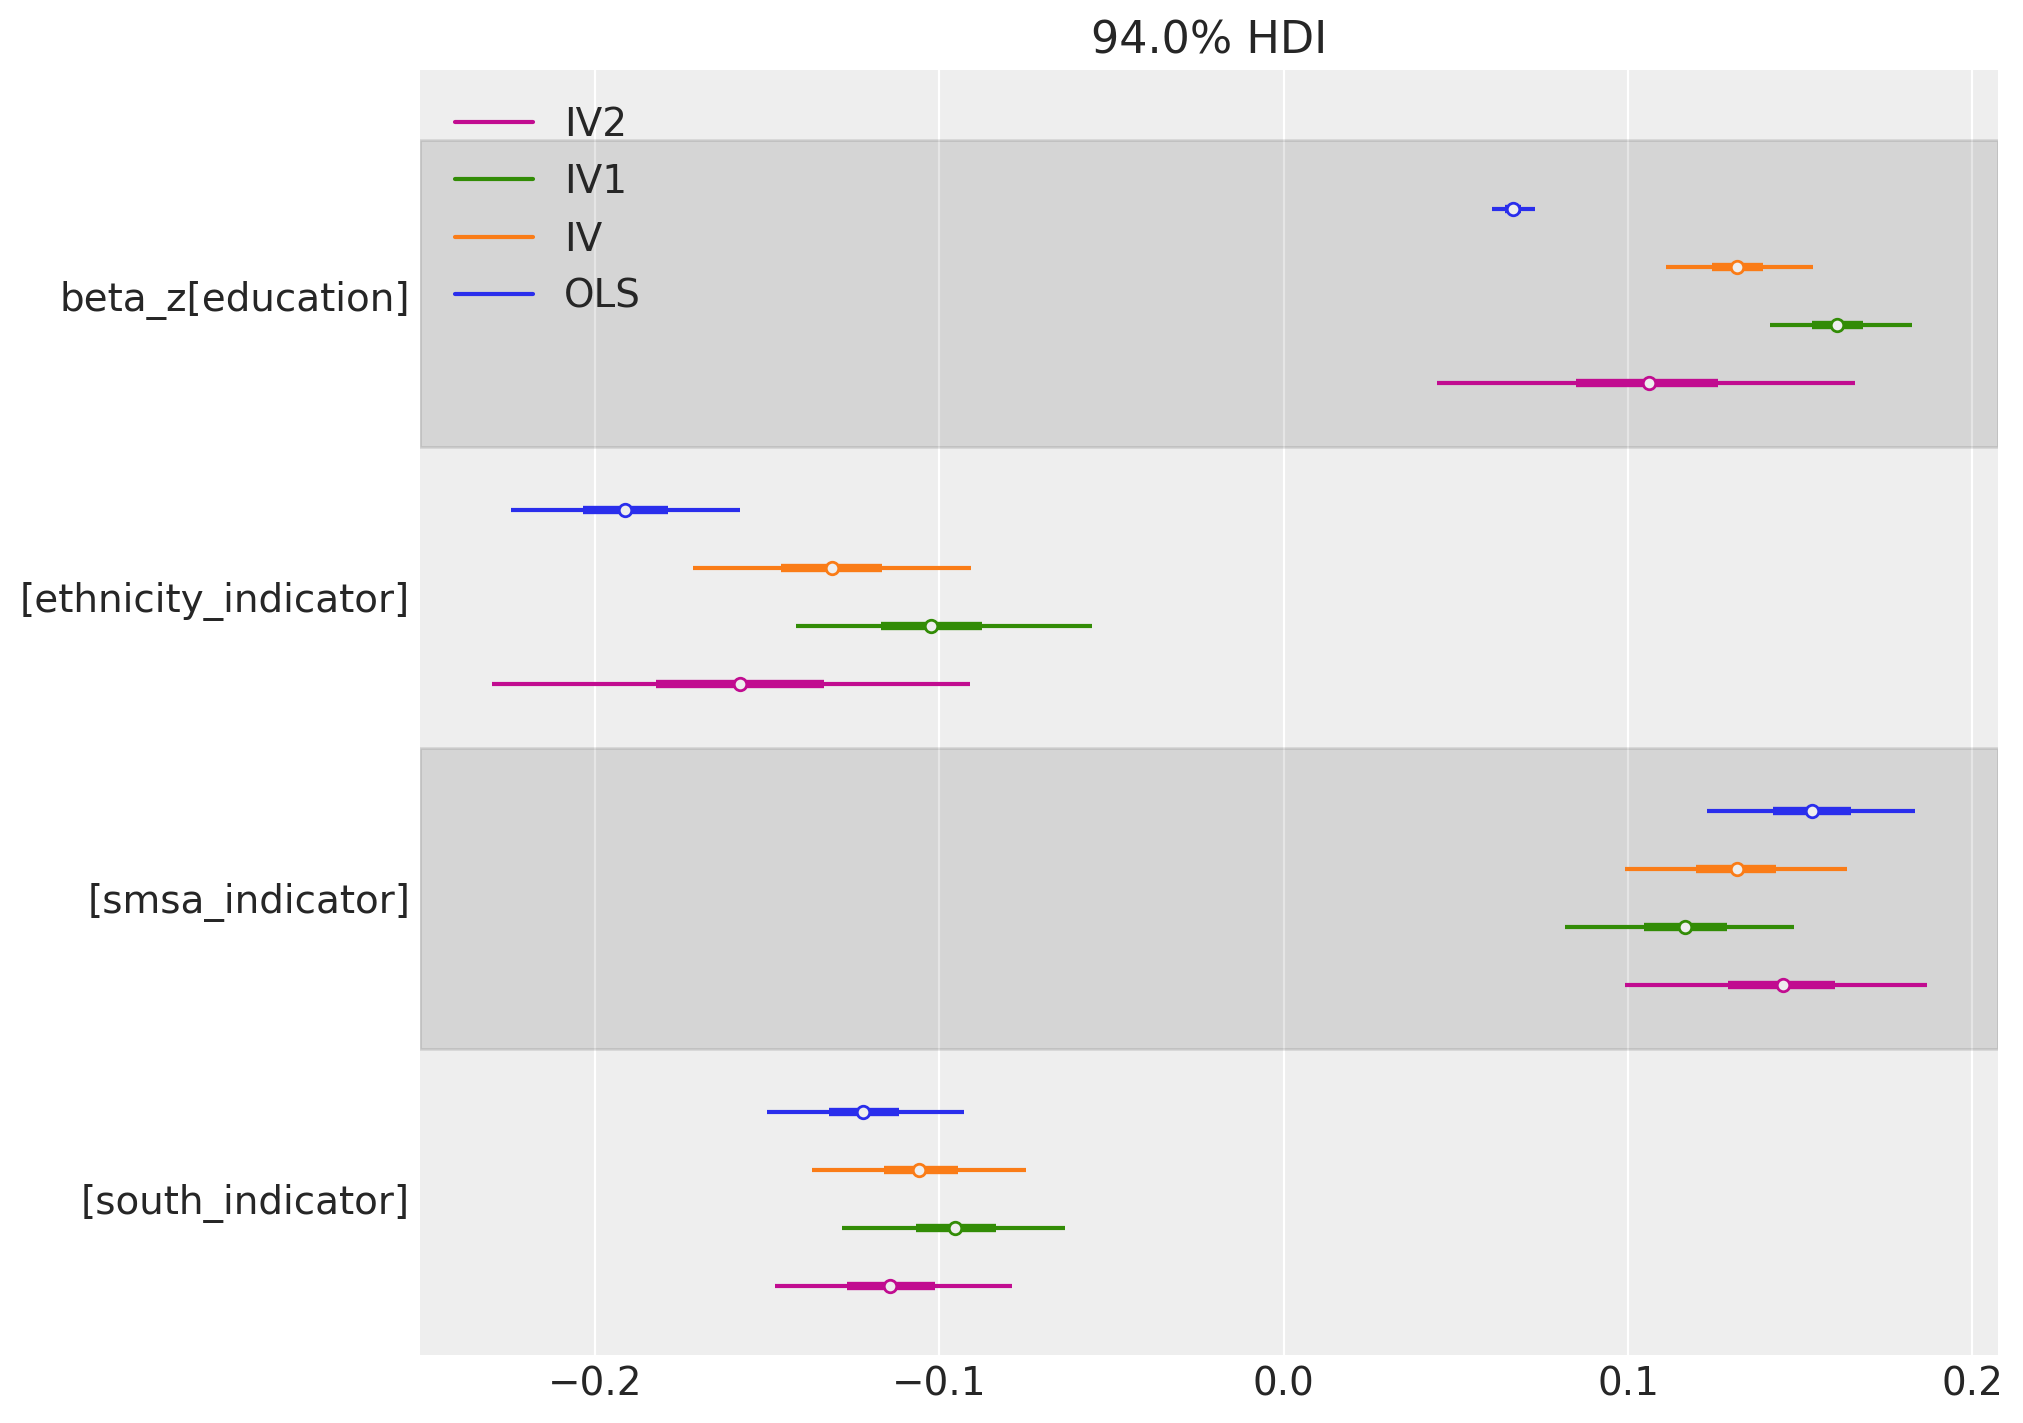

In [23]:
az.plot_forest([idata_reg, iv.idata, iv1.idata, iv2.idata], var_names=['beta_z'], 
               coords={'covariates': ['education', 'ethnicity_indicator', 
                                      'smsa_indicator', 'south_indicator']}, combined=True, 
               model_names=['OLS', 'IV', 'IV1', 'IV2'], figsize=(10, 7));

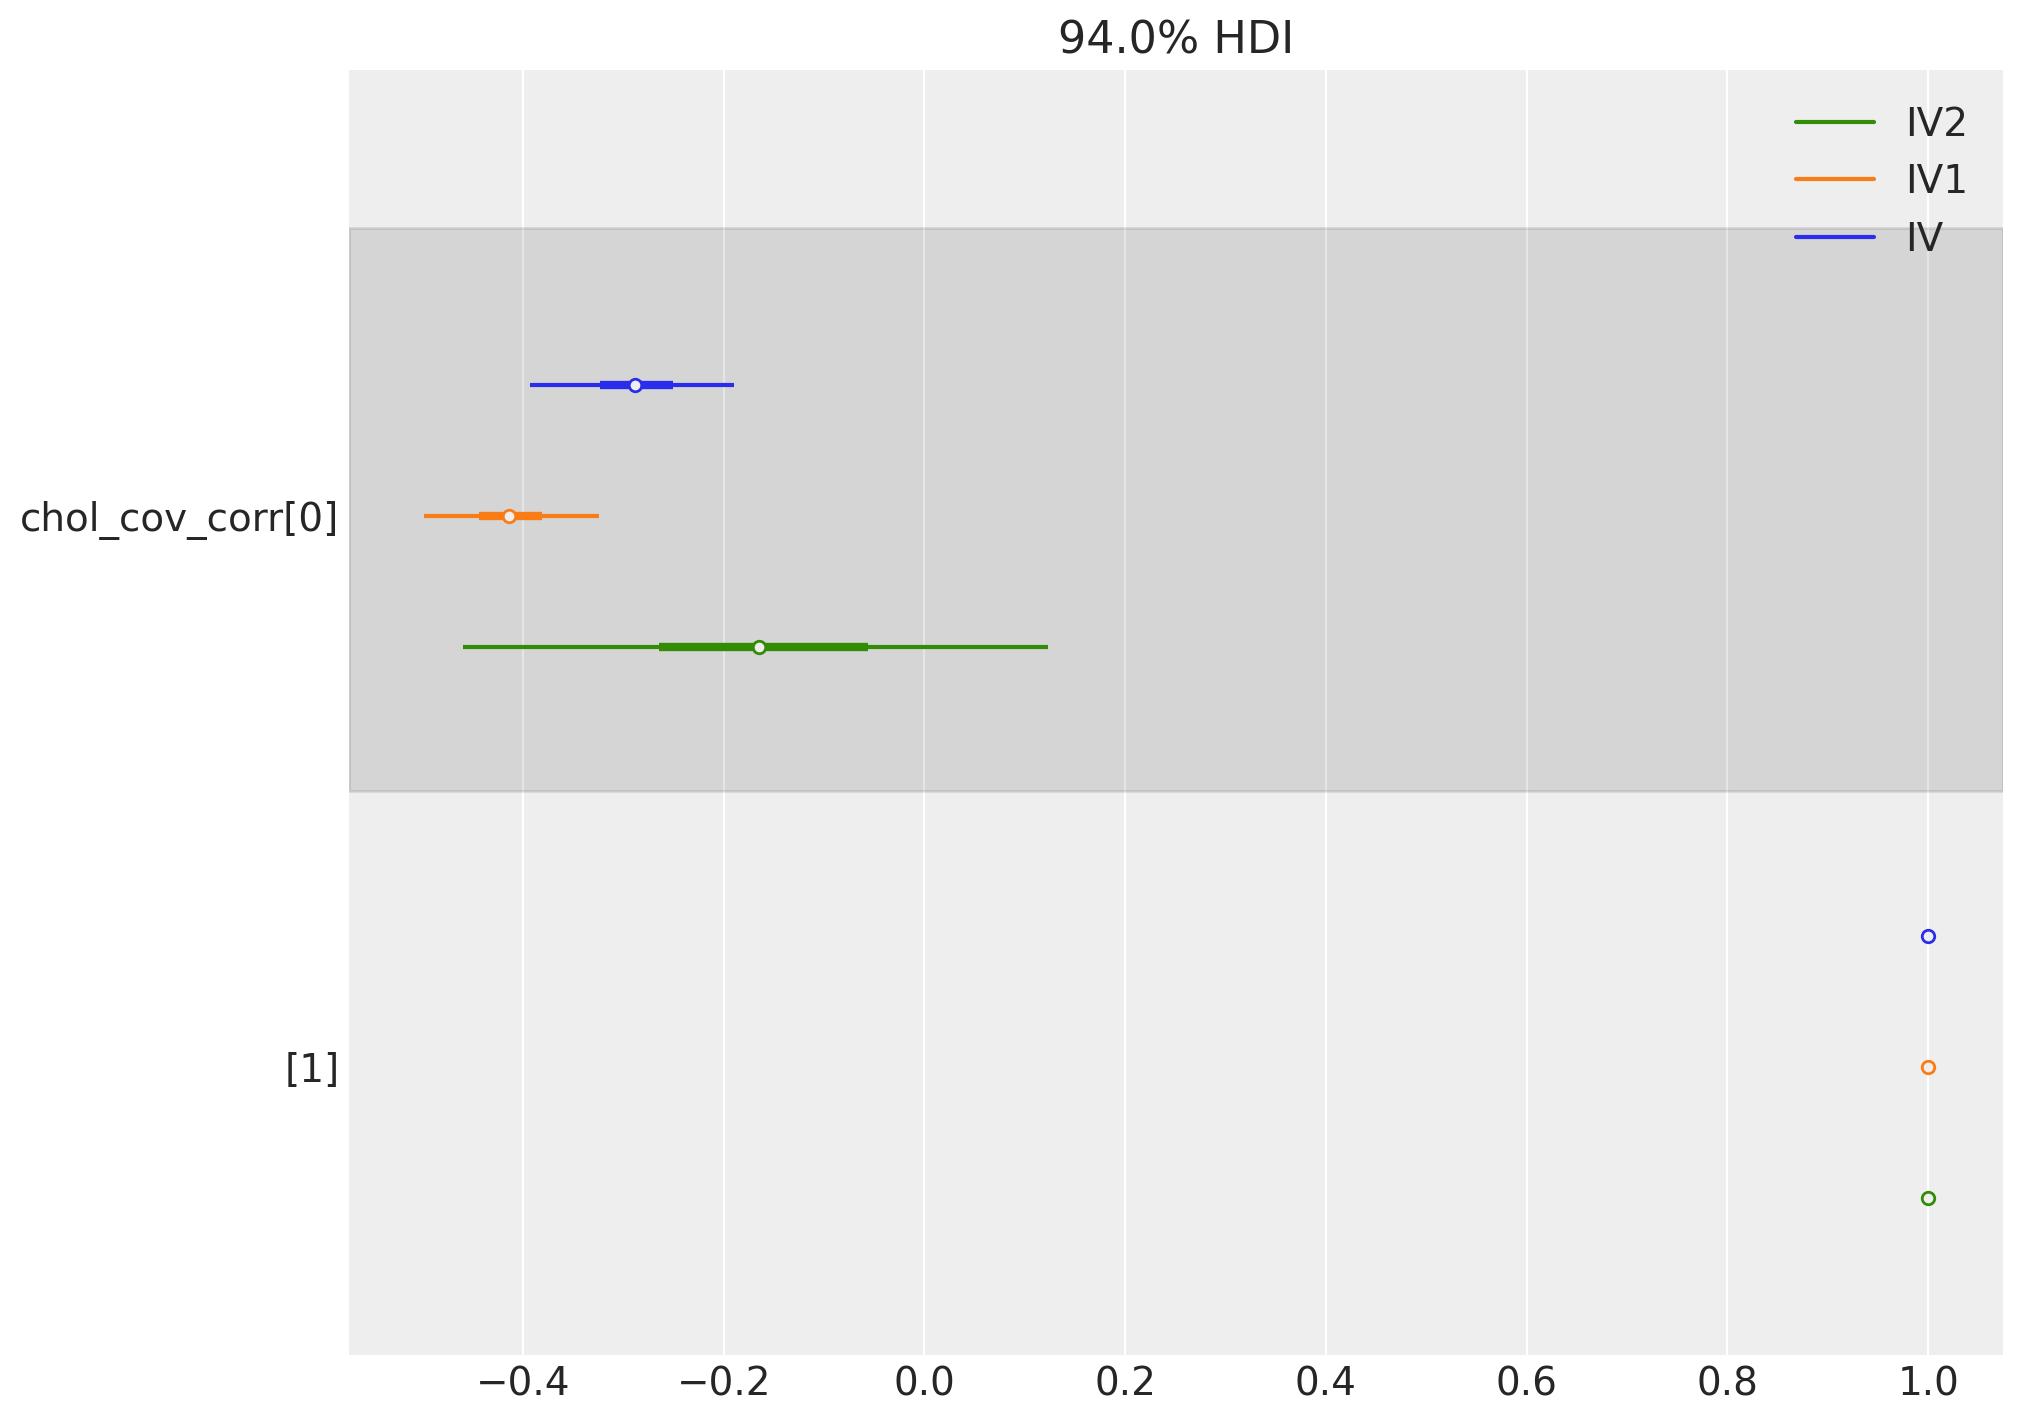

In [24]:
az.plot_forest([iv.idata, iv1.idata, iv2.idata], var_names=['chol_cov_corr'], 
               coords={'chol_cov_corr_dim_1': [1]}, combined=True, 
               model_names=['IV', 'IV1', 'IV2'], figsize=(10, 7));

### Model Evaluation in Outcome Space

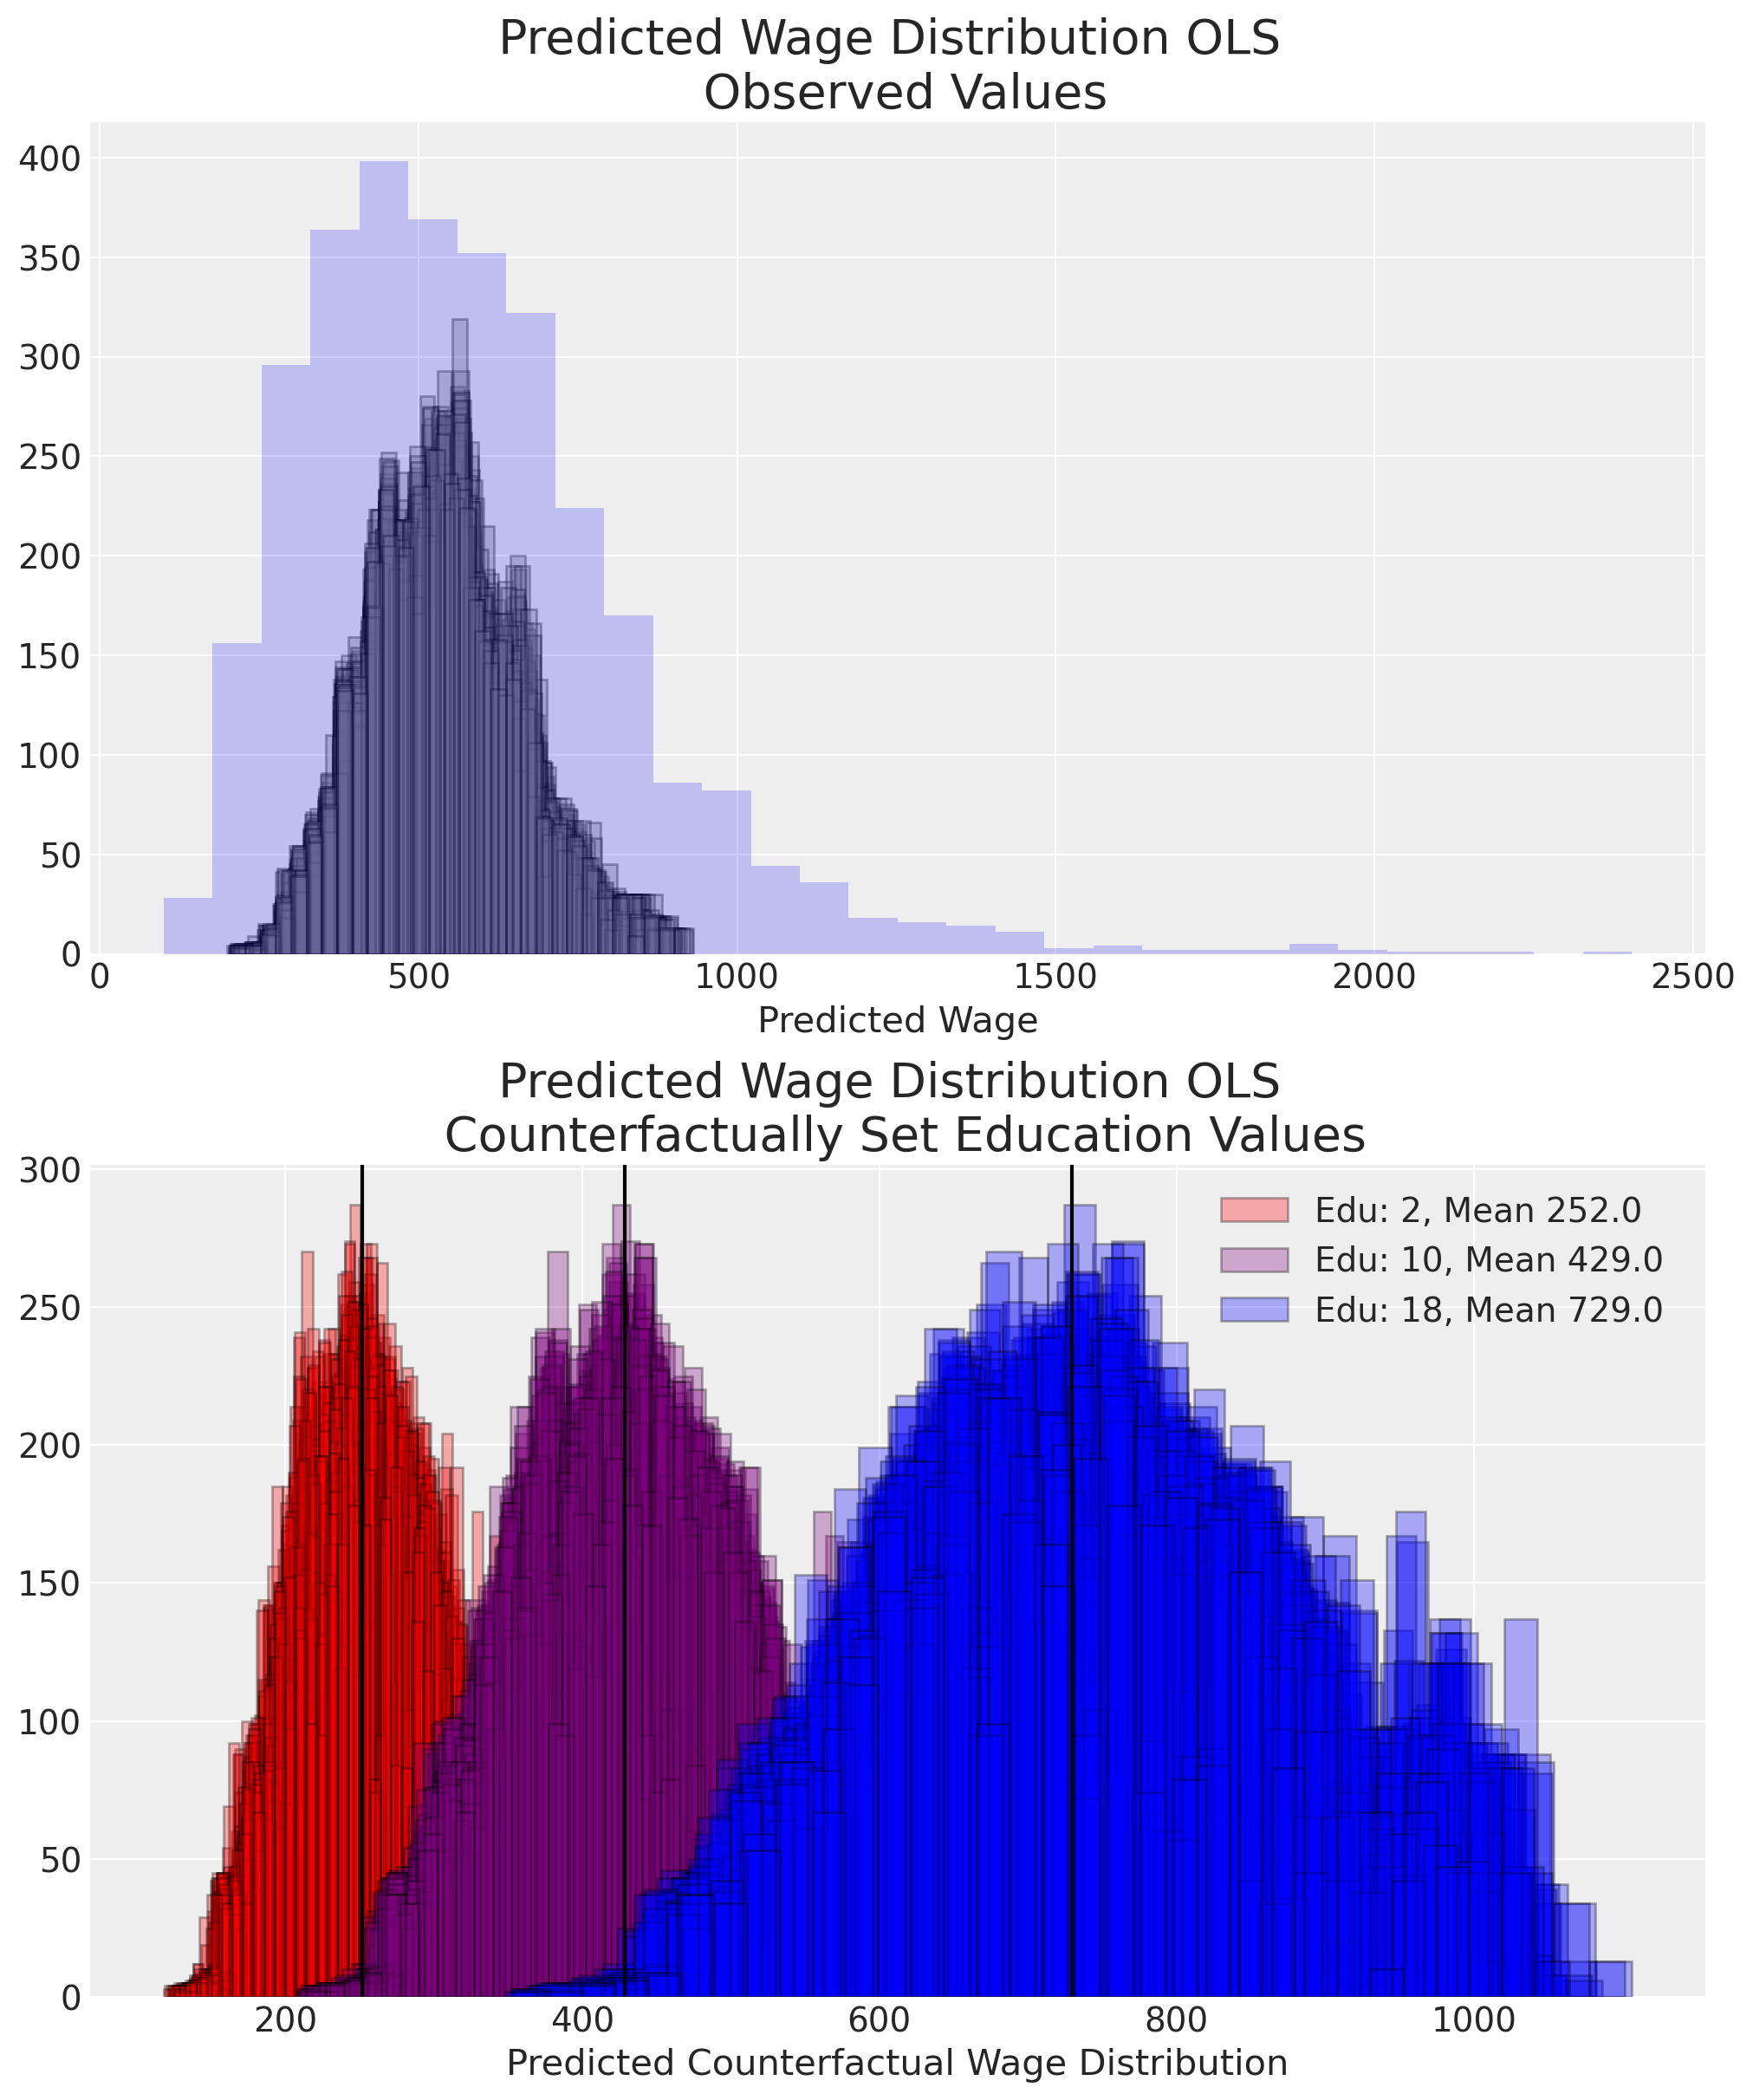

In [25]:
def make_compare_plot(iv, y, model_name, columns):
    data = df.copy()
    data['Intercept'] = 1
    covariate_df = data[covariates]
    params = az.extract(iv['posterior']['beta_z'])['beta_z']

    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    axs = axs.flatten()
    for i in range(100):
        axs[0].hist(np.exp(np.dot(covariate_df, params[:, i].T)), alpha=0.3, bins=30, ec='black', color='grey')
    axs[0].set_title(f"Predicted Wage Distribution {model_name} \n Observed Values", fontsize=20)
    axs[0].hist(np.exp(y), bins=30, alpha=0.2, color='blue')
    axs[0].set_xlabel("Predicted Wage")
    for c, ed in zip(['red', 'purple', 'blue'],[2, 10, 18]):
        temp = covariate_df.copy()
        temp['education'] = ed
        means = []
        for i in range(100):
            dist = np.exp(np.dot(temp, params[:, i].T))
            means.append(np.mean(dist))
            if i == 99:
                axs[1].hist(dist, alpha=0.3, bins=30, ec='black', color=c, label=f'Edu: {ed}, Mean {np.round(np.mean(means))} ')
            else:
                axs[1].hist(dist, alpha=0.3, bins=30, ec='black', color=c)
        axs[1].axvline(np.mean(means), color='k')
    axs[1].set_title(f"Predicted Wage Distribution {model_name} \n Counterfactually Set Education Values", fontsize=20)
    axs[1].set_xlabel("Predicted Counterfactual Wage Distribution")
    axs[1].legend()


covariates = list(idata_reg['posterior']['beta_z']['covariates'].values)
make_compare_plot(idata_reg, data['log_wage'], 'OLS', covariates)

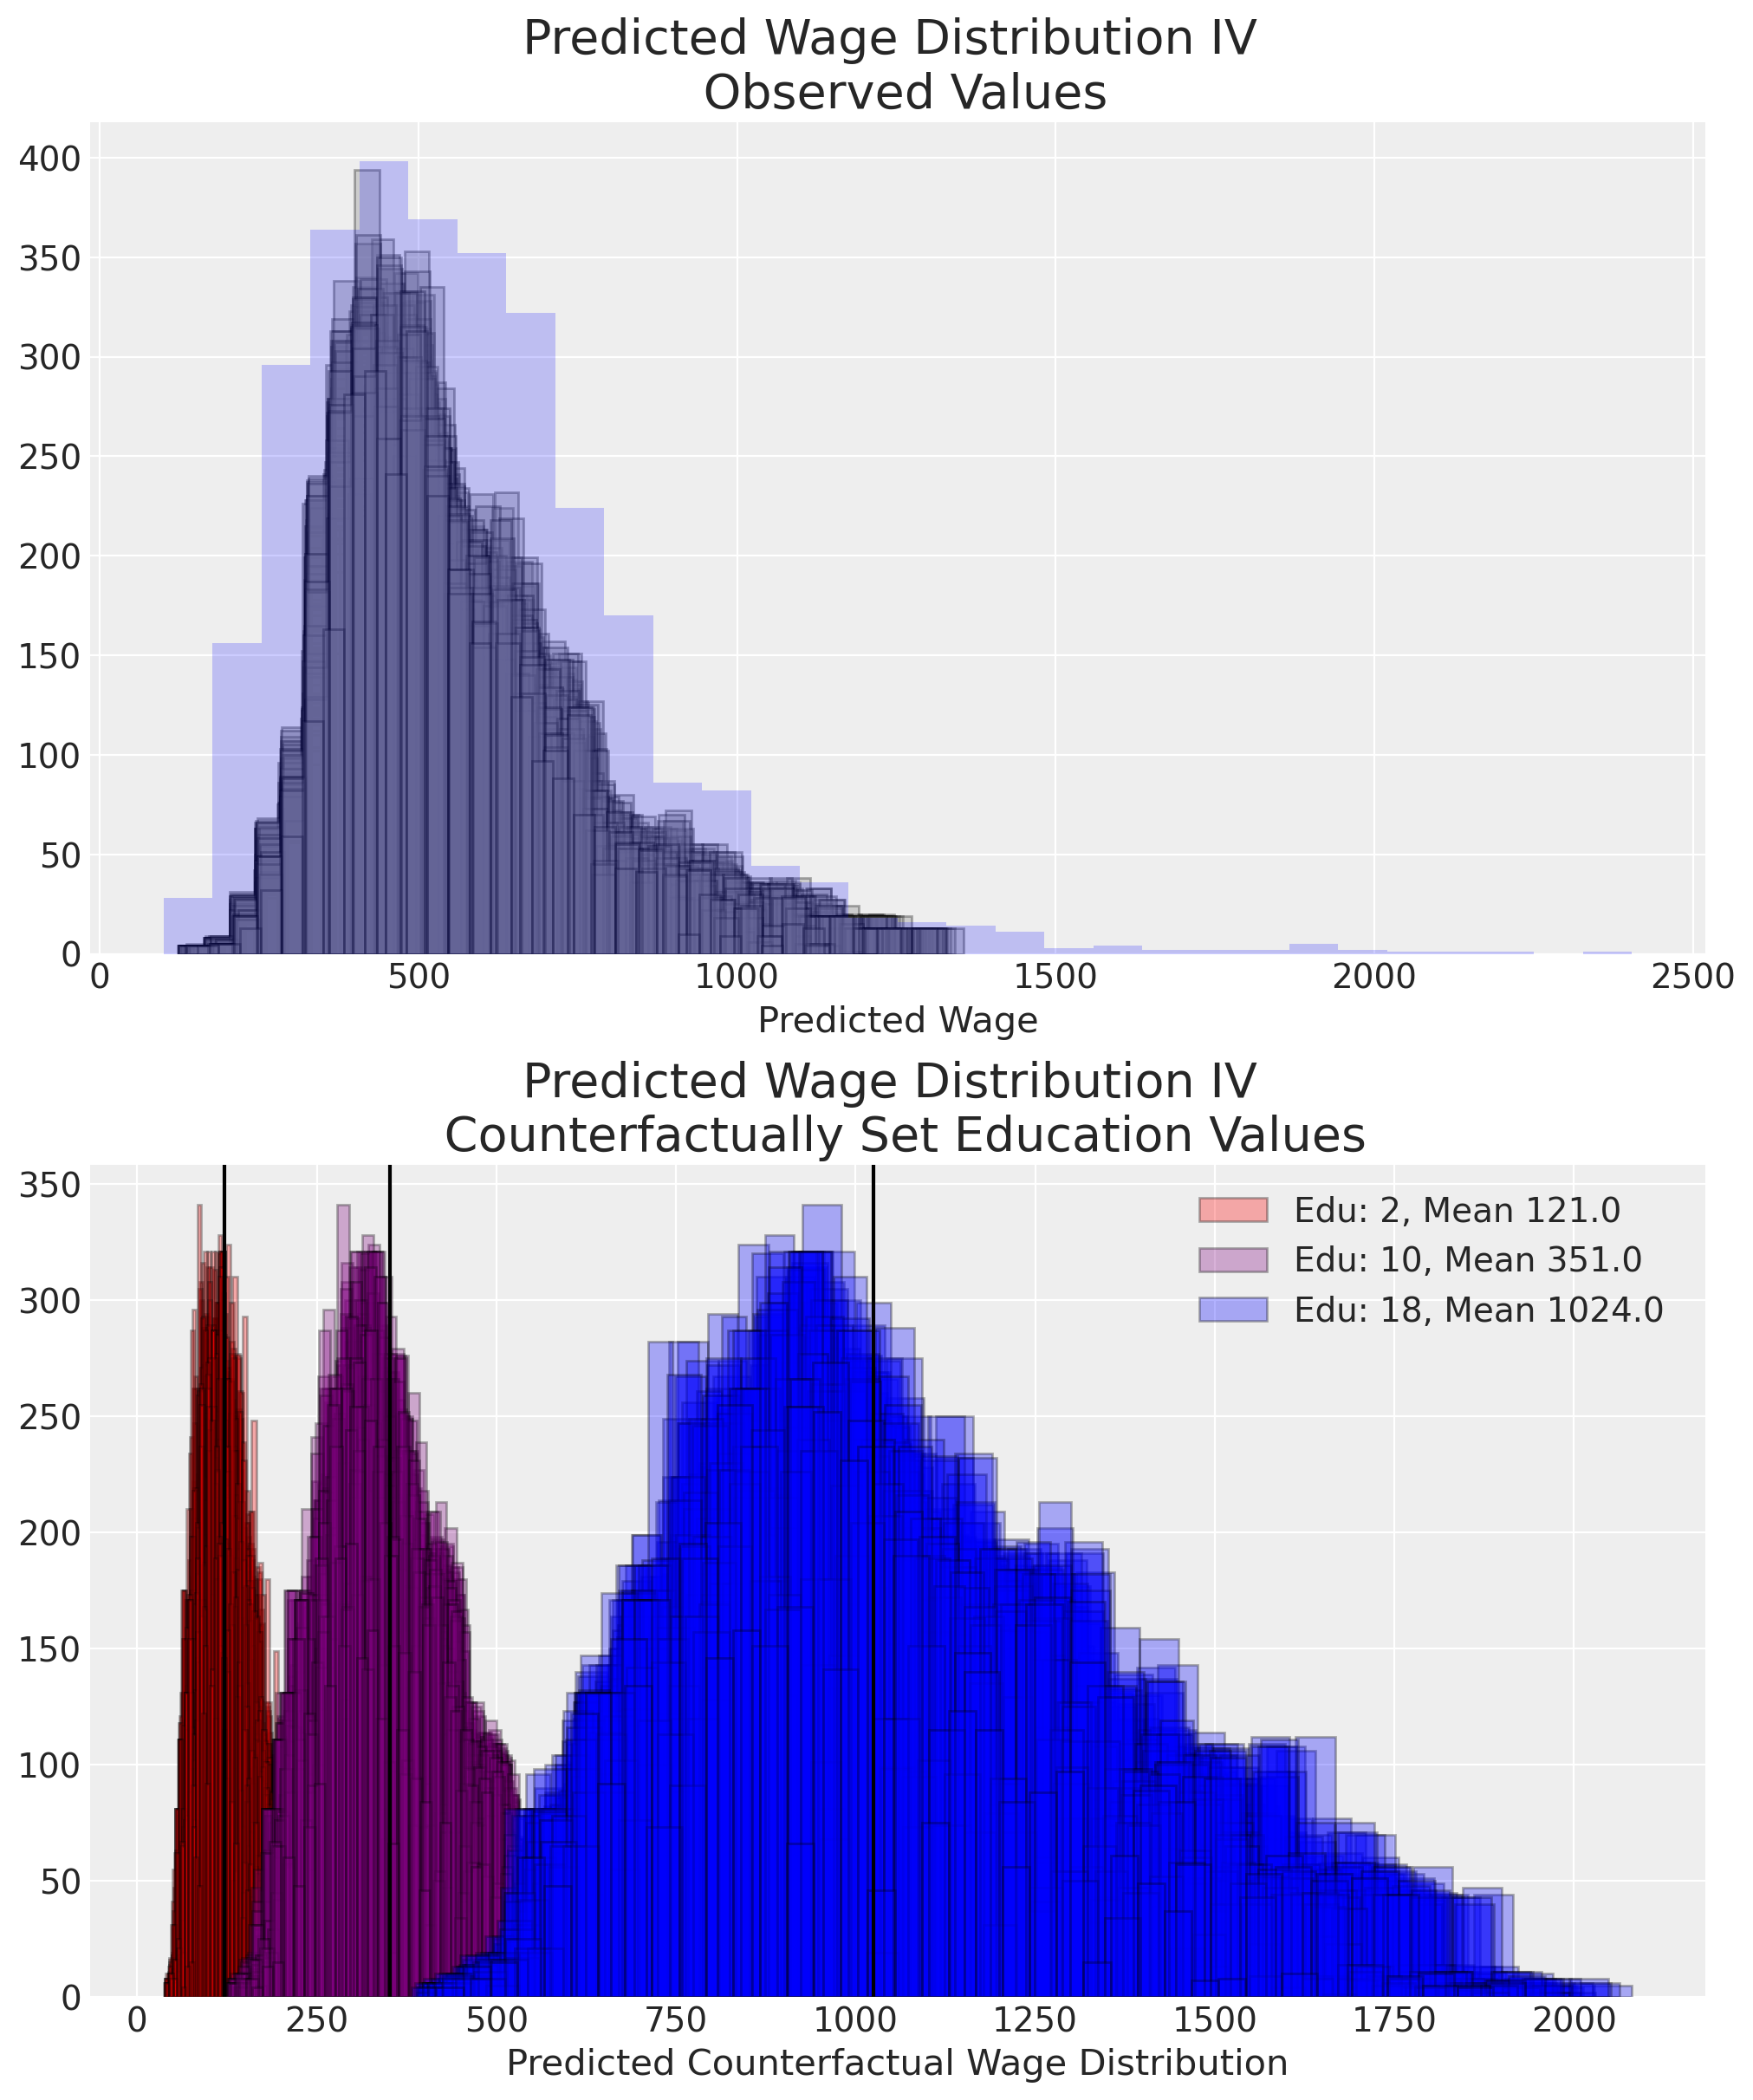

In [26]:
covariates = list(iv.idata['posterior']['beta_z']['covariates'].values)
make_compare_plot(iv.idata, data['log_wage'], 'IV', covariates)

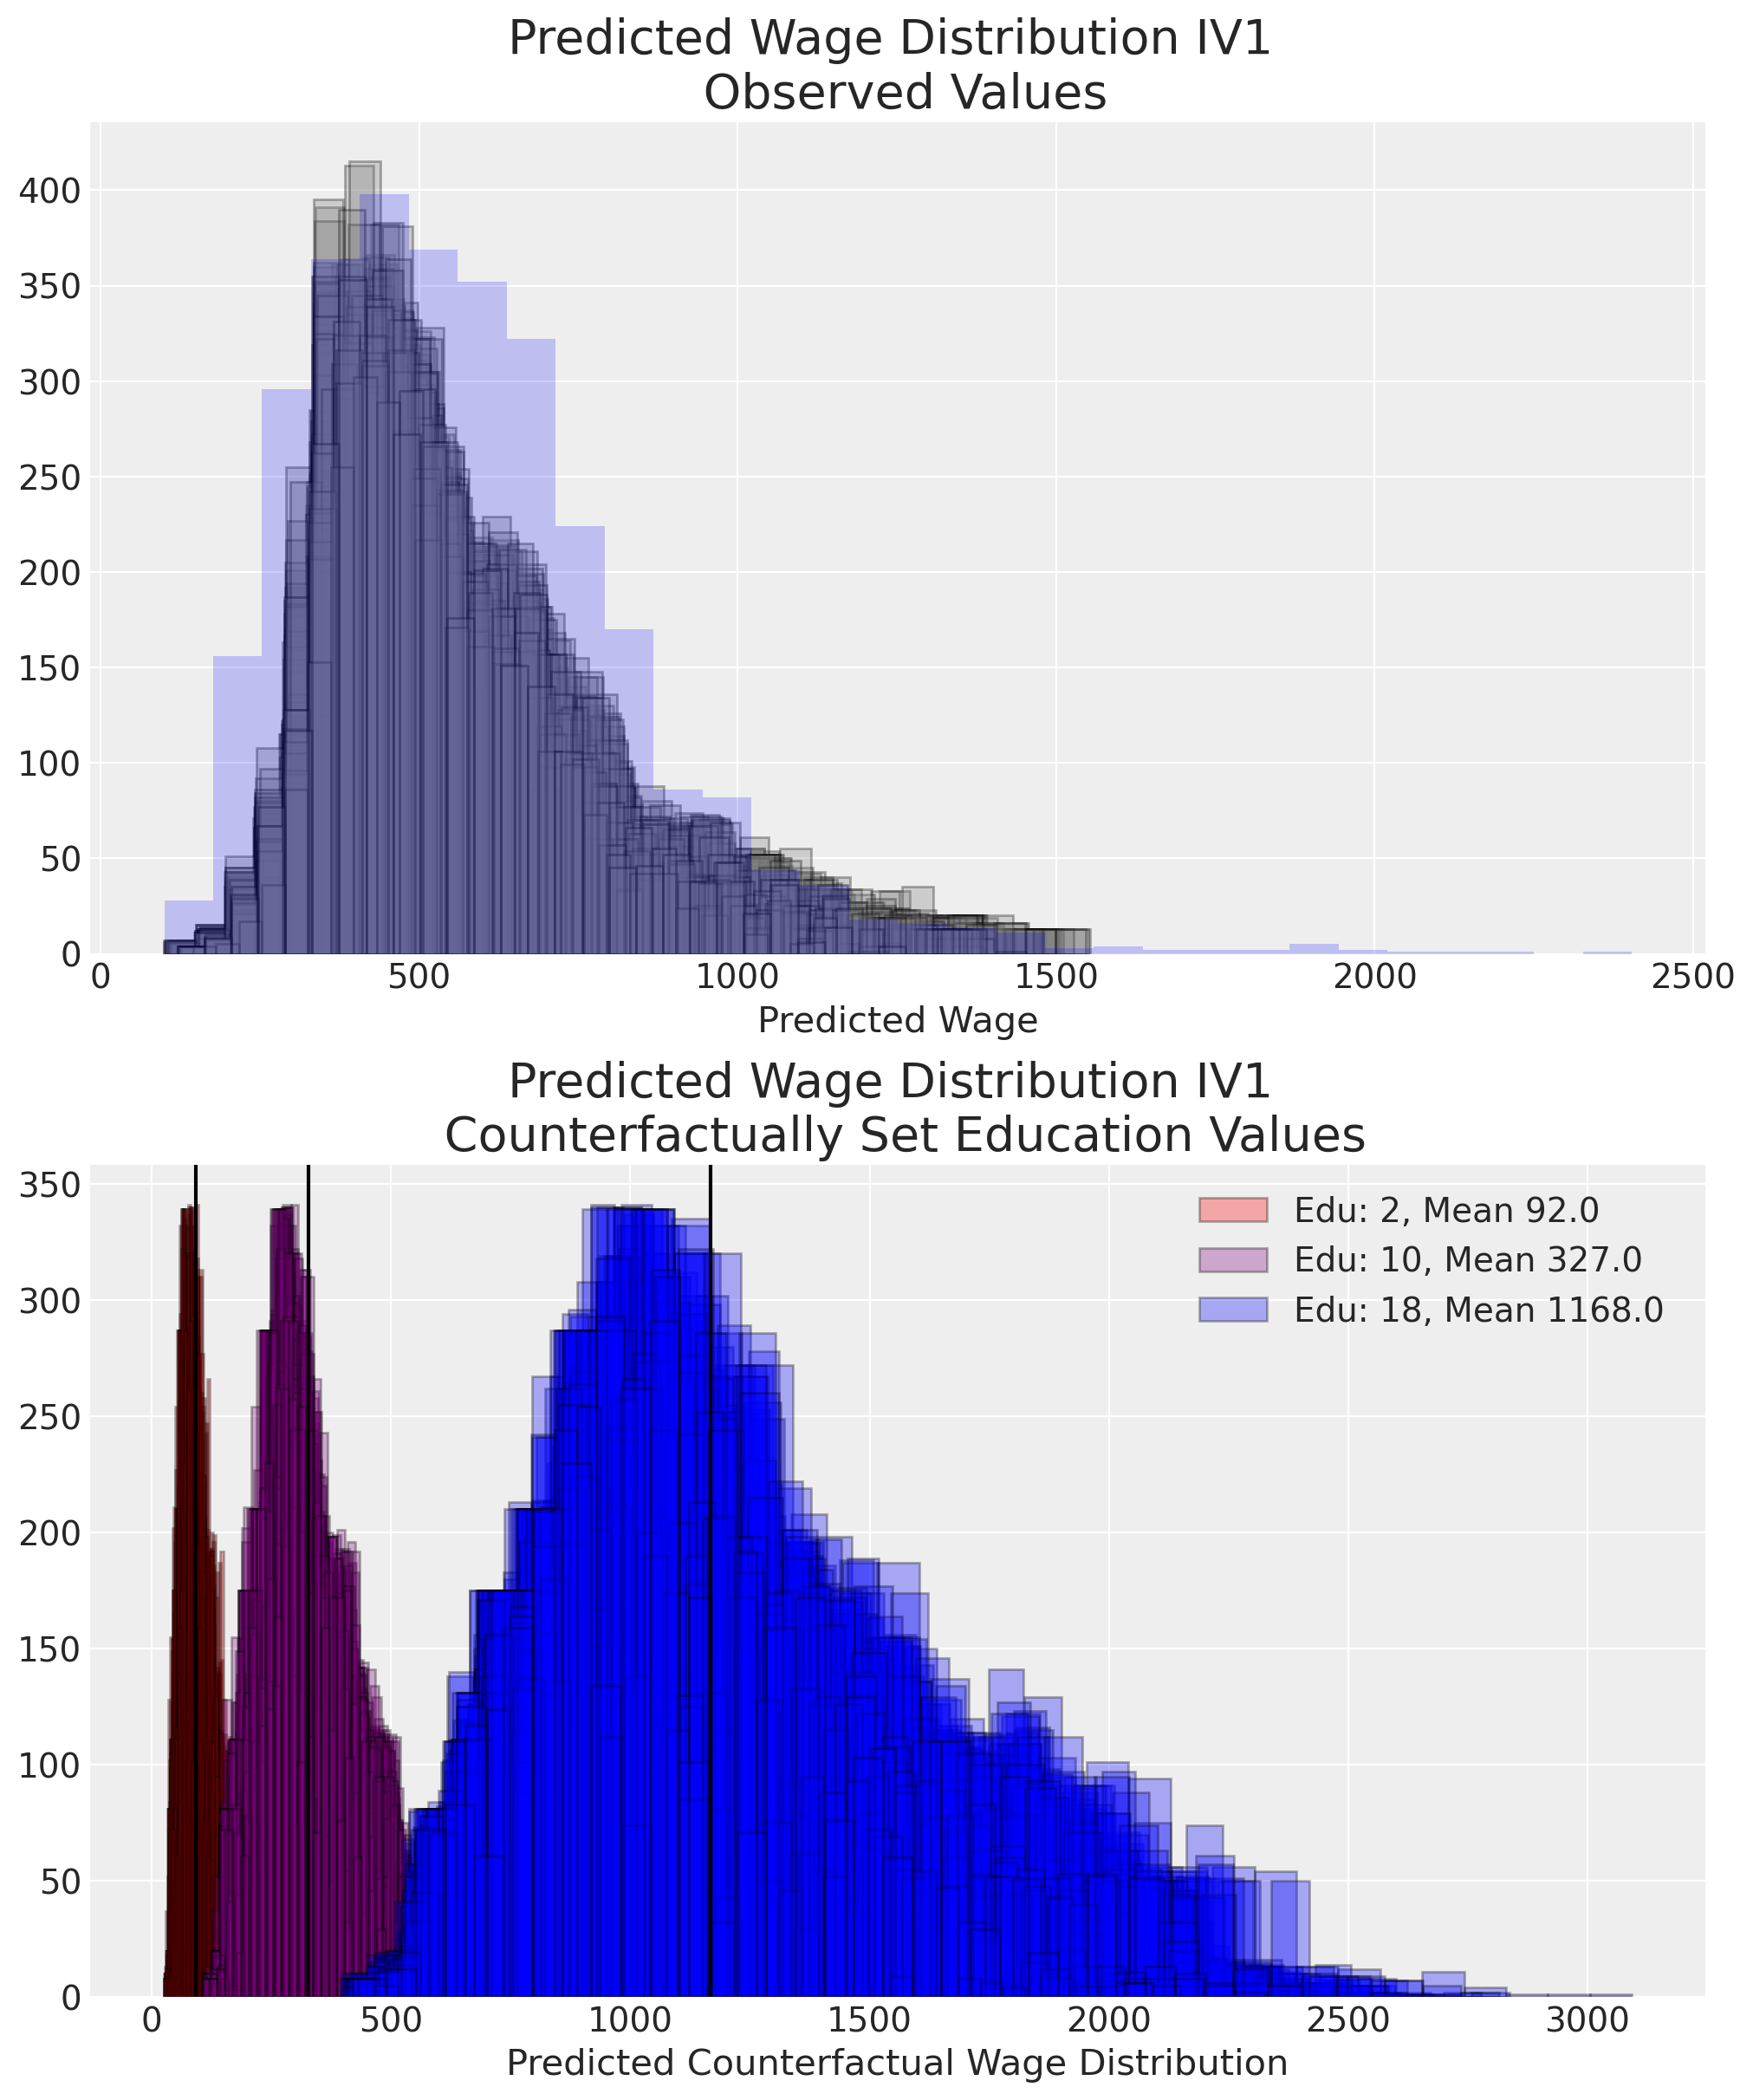

In [27]:
covariates = list(iv1.idata['posterior']['beta_z']['covariates'].values)
make_compare_plot(iv1.idata, data['log_wage'], 'IV1', covariates)

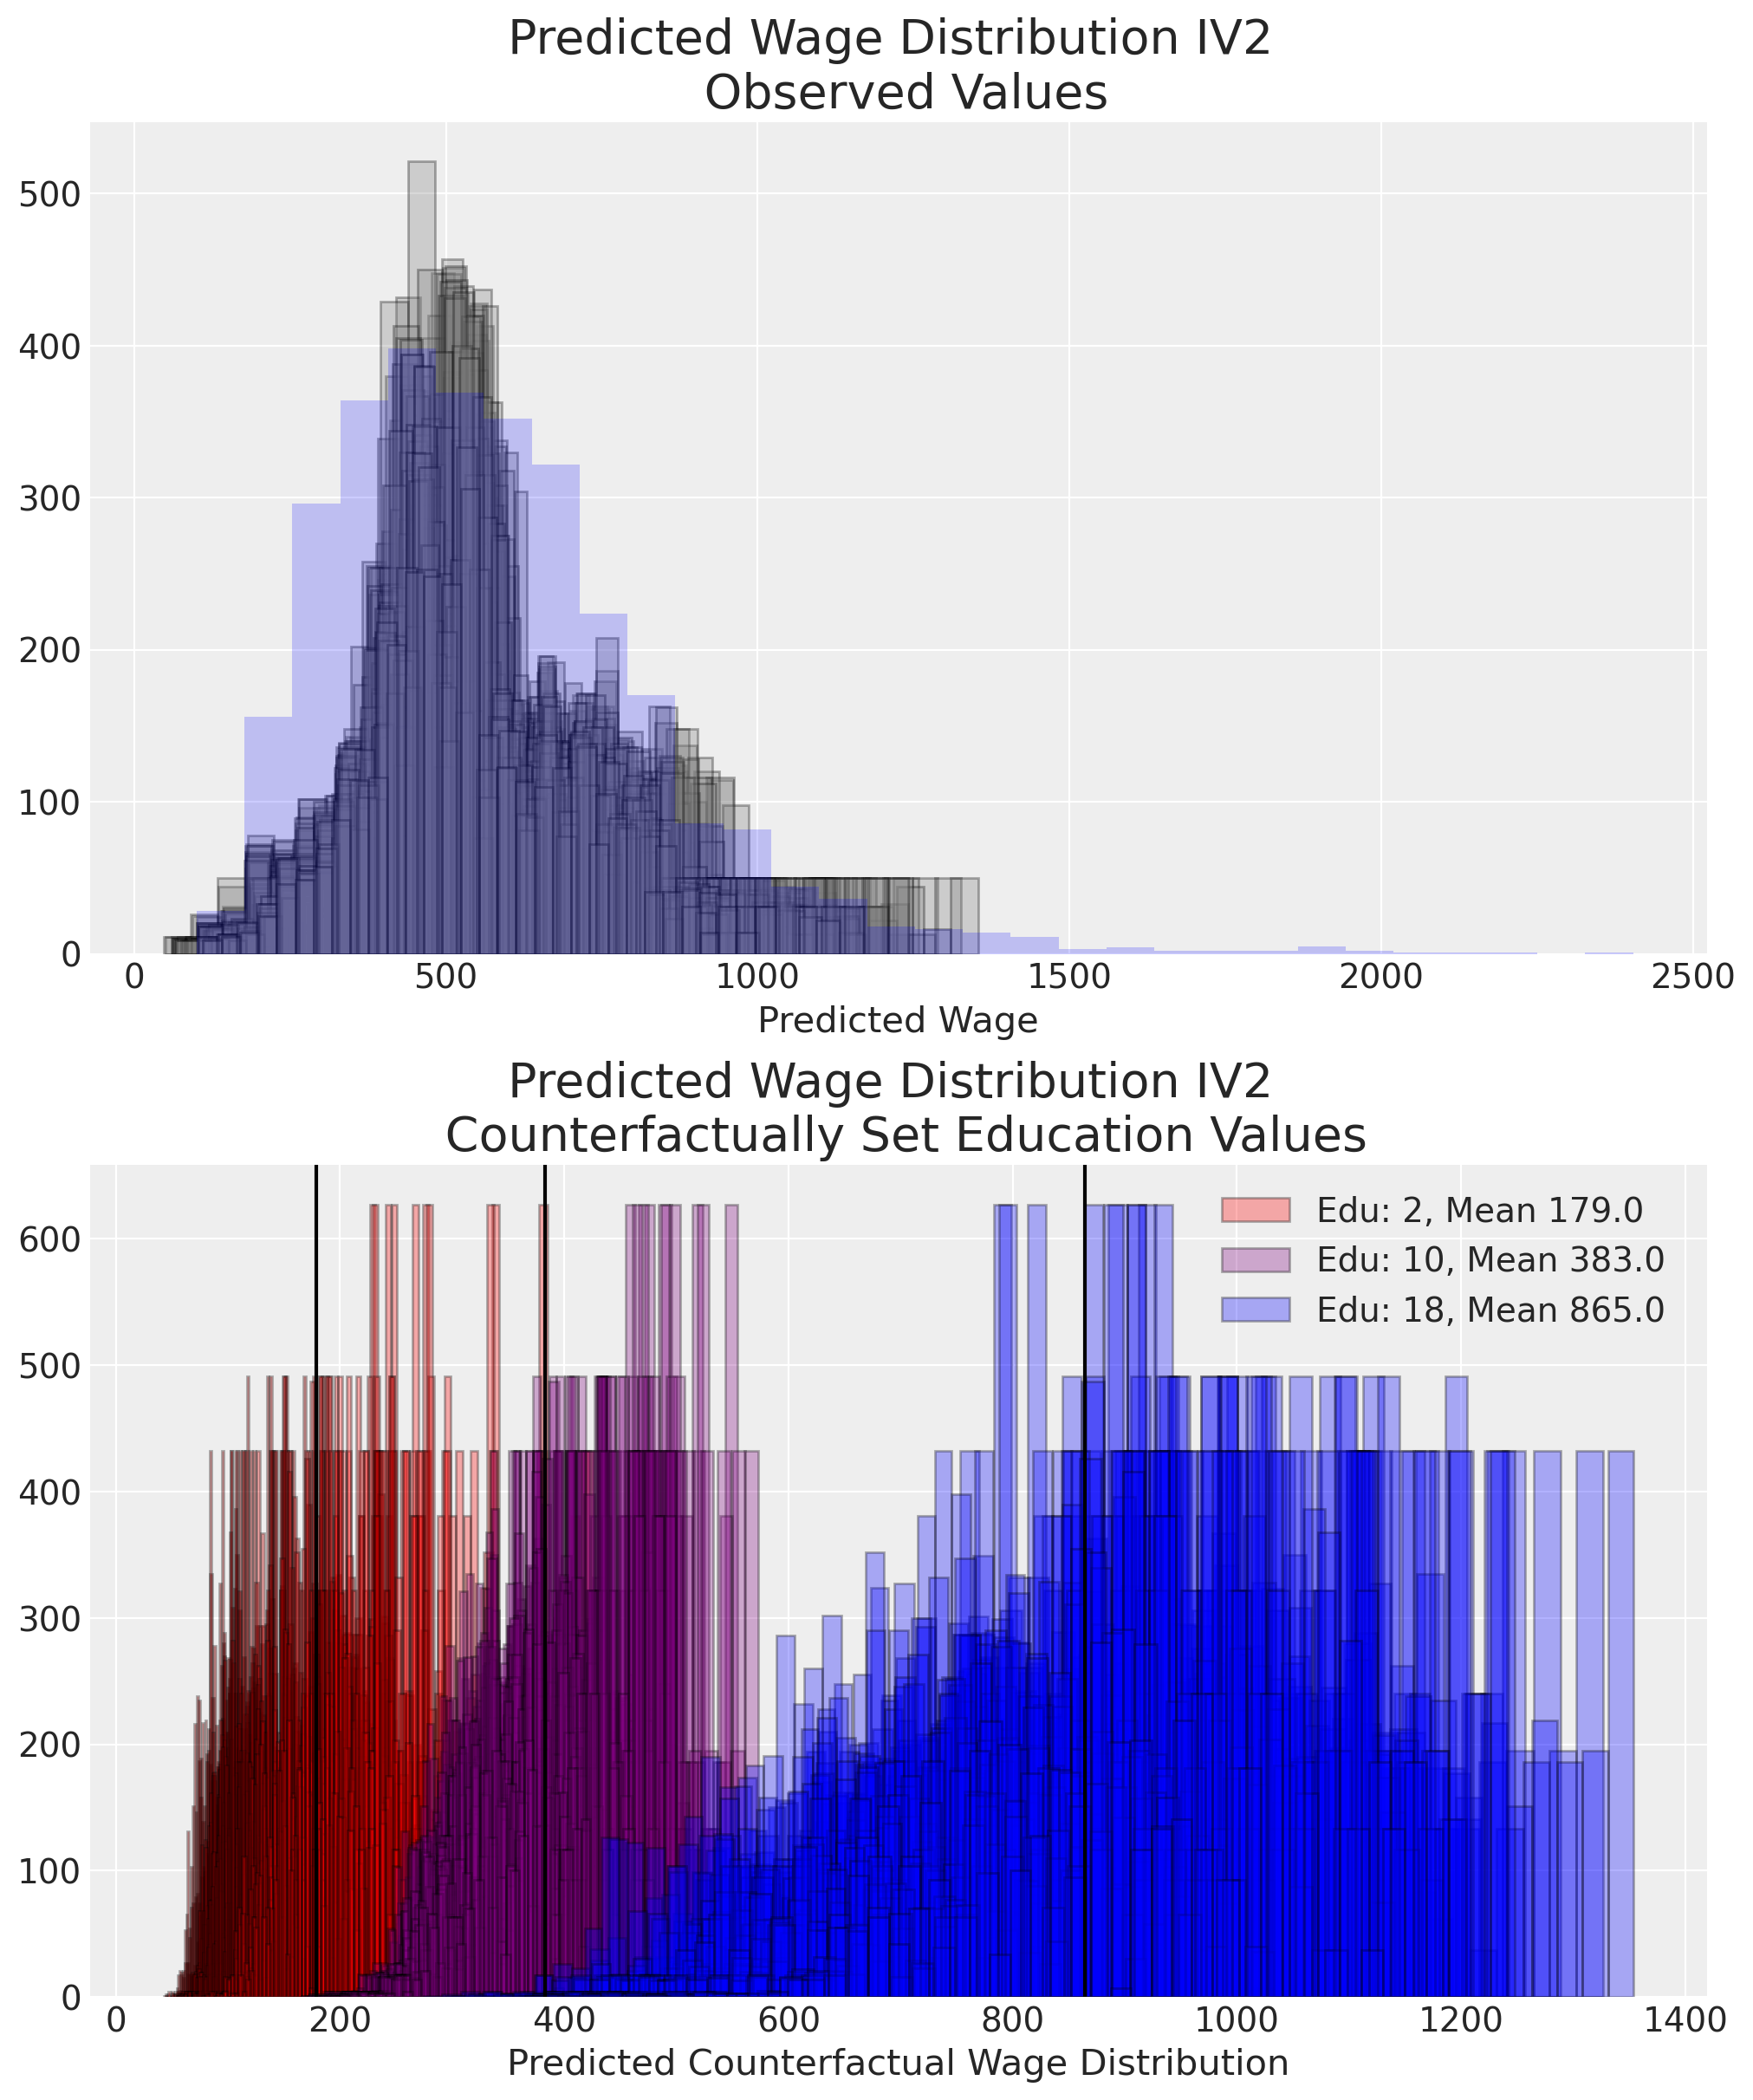

In [28]:
covariates = list(iv2.idata['posterior']['beta_z']['covariates'].values)
make_compare_plot(iv2.idata, data['log_wage'], 'IV2', covariates)

In [29]:
az.compare({'IV': iv.idata, 'IV1': iv1.idata, 'IV2': iv2.idata})

rank     elpd_loo      p_loo  elpd_diff        weight         se  \
IV1     0 -7586.972396  15.439343   0.000000  8.081314e-01  59.036662   
IV      1 -7588.739918  14.693748   1.767523  1.918686e-01  59.025250   
IV2     2 -7589.599149  15.287069   2.626753  1.110223e-16  59.024892   

          dse  warning scale  
IV1  0.000000    False   log  
IV   2.395282    False   log  
IV2  2.562789    False   log